In [3]:
from fastlane_bot.tools.cpc import ConstantProductCurve as CPC, CPCContainer, T, CPCInverter, Pair
from fastlane_bot.tools.optimizer import CPCArbOptimizer, F, MargPOptimizer, SimpleOptimizer
from fastlane_bot.tools.analyzer import CPCAnalyzer
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(Pair))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPC))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPCArbOptimizer))

from fastlane_bot.testing import *
#plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]
from fastlane_bot import __VERSION__
require("3.0", __VERSION__)

SimplePair v2.1 (18/May/2023)
ConstantProductCurve v2.14 (23/May/2023)
CPCArbOptimizer v4.0 (10/May/2023)
imported m, np, pd, plt, os, sys, decimal; defined iseq, raises, require
Version = 3-b2.2 [requirements >= 3.0 is met]


# CPC and Optimizer in Fastlane [NBTest002]

In [4]:
try:
    market_df = pd.read_csv("_data/NBTEST_002_Curves.csv.gz")
except:
    market_df = pd.read_csv("fastlane_bot/tests/nbtest/_data/NBTEST_002_Curves.csv.gz")
CCmarket = CPCContainer.from_df(market_df)

## description

In [9]:
d = CCmarket.bycid("167").description().splitlines()
d0 = """
cid      = 167 [167]
primary  = WETH/DAI [WETH/DAI]
pp       = 1,826.764318 DAI per WETH
pair     = DAI/WETH [DAI/WETH]
tknx     =     3,967,283.591895 DAI        [virtual:        3,967,283.592]
tkny     =         2,171.754481 WETH       [virtual:            2,171.754]
p        = 0.0005474159913752679 [min=None, max=None] WETH per DAI
fee      = 0.003
descr    = sushiswap_v2 DAI/WETH 0.003
""".strip().splitlines()
d0 = [l.strip() for l in d0]
assert d == d0
for l in d0:
    print(l)

cid      = 167 [167]
primary  = WETH/DAI [WETH/DAI]
pp       = 1,826.764318 DAI per WETH
pair     = DAI/WETH [DAI/WETH]
tknx     =     3,967,283.591895 DAI        [virtual:        3,967,283.592]
tkny     =         2,171.754481 WETH       [virtual:            2,171.754]
p        = 0.0005474159913752679 [min=None, max=None] WETH per DAI
fee      = 0.003
descr    = sushiswap_v2 DAI/WETH 0.003


## bycids

In [4]:
CC = CCmarket

In [5]:
assert len(CC.bycids()) == len(CC)
assert type(CC.bycids()) == type(CC)
assert type(CC.bycids(ascc=False)) == tuple
for c in CC:
    assert isinstance(c.cid, str), f"{c.cid} is not of type str"
cids = [c.cid for c in CC]
assert raises(CC.bycids, include="foo", endswith="bar") == 'include and endswith cannot be used together'
assert raises(CC.bycids,"167, 168, 169")
CC1 = CC.bycids(["167", "168", "169"])
assert len(CC1) == 3
assert [c.cid for c in CC1] == ['167', '168', '169']
CC2 = CC.bycids(endswith="11")
assert len(CC2) == 5
assert [c.cid for c in CC2] == ['211', '311', '411', '511', '611']
CC3 = CC.bycids(endswith="11", exclude=['311', '411'])
assert [c.cid for c in CC3] == ['211', '511', '611']

## pairo and primary

In [6]:
assert Pair.n("WETH-eeee") == "WETH"
assert Pair.n("WETH") == "WETH"
assert Pair.n("USDC-uuuu/WETH-eeee") == "USDC/WETH"

In [7]:
pairo = Pair("USDC-uuuu/WETH-eeee")
assert pairo.isprimary == False
assert raises (Pair, tknb='USDC-uuuu', tknq='WETH-eeee')
assert pairo.tknb == 'USDC-uuuu'
assert pairo.tknq == 'WETH-eeee'
assert pairo.tknb_n == 'USDC'
assert pairo.tknq_n == 'WETH'
assert pairo.tknx == 'USDC-uuuu'
assert pairo.tkny == 'WETH-eeee'
assert pairo.tknx_n == 'USDC'
assert pairo.tkny_n == 'WETH'
assert pairo.pair == 'USDC-uuuu/WETH-eeee'
assert pairo.pair_n == 'USDC/WETH'
assert pairo.primary == 'WETH-eeee/USDC-uuuu'
assert pairo.primary_n == 'WETH/USDC'
assert pairo.secondary == pairo.pair
assert pairo.secondary_n == pairo.pair_n
assert pairo.primary_tknb == "WETH"
assert pairo.primary_tknq == "USDC"

In [8]:
pairo = Pair("WETH-eeee/USDC-uuuu")
assert pairo.isprimary == True
assert pairo.tknq == 'USDC-uuuu'
assert pairo.tknb == 'WETH-eeee'
assert pairo.tknq_n == 'USDC'
assert pairo.tknb_n == 'WETH'
assert pairo.tkny == 'USDC-uuuu'
assert pairo.tknx == 'WETH-eeee'
assert pairo.tkny_n == 'USDC'
assert pairo.tknx_n == 'WETH'
assert pairo.pair == 'WETH-eeee/USDC-uuuu'
assert pairo.pair_n == 'WETH/USDC'
assert pairo.primary == pairo.pair
assert pairo.primary_n == pairo.pair_n
assert pairo.secondary == 'USDC-uuuu/WETH-eeee'
assert pairo.secondary_n == 'USDC/WETH'
assert pairo.primary_tknb == "WETH"
assert pairo.primary_tknq == "USDC"

In [9]:
c1 = CPC.from_pk(pair="USDC-uuuu/WETH-eeee", p=1, k=100)
c2 = CPC.from_pk(pair="WETH-eeee/USDC-uuuu", p=1, k=100)
CC = CPCContainer([c1,c2])
assert c1.pairo.primary == 'WETH-eeee/USDC-uuuu'
assert c2.pairo.primary == 'WETH-eeee/USDC-uuuu'
assert c1.primary == c1.pairo.primary
assert CC.pairs() == {'WETH-eeee/USDC-uuuu'}
assert CC.pairs(standardize=True) == CC.pairs()
assert CC.pairs(standardize=False) == {'USDC-uuuu/WETH-eeee', 'WETH-eeee/USDC-uuuu'}

In [10]:
assert Pair("WETH/USDC").isprimary == True
assert Pair("USDC/WETH").isprimary == False

## buysell

In [11]:
# selling ETH at 2000-2001 USDC per ETH
c1 = CPC.from_carbon(pair="WETH/USDC", tkny="WETH", yint=10, y=10, pa=1/2000, pb=1/2001, isdydx=True)
assert c1.pair == "USDC/WETH"
assert c1.primary == "WETH/USDC"
assert c1.pairo.isprimary == False
assert c1.buysell(verbose=True, withprice=True) == 'sell-WETH @ 2000.00 USDC per WETH'
assert c1.buysell(verbose=False) == "s"
assert c1.buysell() == "s"

In [12]:
# selling ETH at 2000-2001 USDC per ETH
c1 = CPC.from_carbon(pair="WETH/USDC", tkny="WETH", yint=10, y=10, pa=2000, pb=2001, isdydx=False)
assert c1.pair == "USDC/WETH"
assert c1.primary == "WETH/USDC"
assert c1.pairo.isprimary == False
assert c1.buysell(verbose=True, withprice=True) == 'sell-WETH @ 2000.00 USDC per WETH'
assert c1.buysell(verbose=False) == "s"
assert c1.buysell(verbose=False, withprice=True) == ('s', 2000.0000000000005)
assert c1.buysell() == "s"

In [13]:
# buying ETH at 1500-1499 USDC per ETH
c2 = CPC.from_carbon(pair="WETH/USDC", tkny="USDC", yint=10, y=10, pa=1500, pb=1499, isdydx=True)
assert c2.pair == "WETH/USDC"
assert c2.primary == "WETH/USDC"
assert c2.pairo.isprimary == True
assert c2.buysell(verbose=True, withprice=True) == 'buy-WETH @ 1500.00 USDC per WETH'
assert c2.buysell(verbose=False) == "b"
assert c2.buysell(verbose=False, withprice=True) == ('b', 1500.0000000000002)
assert c2.buysell() == "b"

In [14]:
# buying ETH at 1500-1499 USDC per ETH
c2 = CPC.from_carbon(pair="WETH/USDC", tkny="USDC", yint=10, y=10, pa=1500, pb=1499, isdydx=False)
assert c2.pair == "WETH/USDC"
assert c2.primary == "WETH/USDC"
assert c2.pairo.isprimary == True
assert c2.buysell(verbose=True, withprice=True) == 'buy-WETH @ 1500.00 USDC per WETH'
assert c2.buysell(verbose=False) == "b"
assert c2.buysell(verbose=False, withprice=True) == ('b', 1500.0000000000002)
assert c2.buysell() == "b"

In [15]:
# univ3 1899-1901 @ 1900 USDC per WETH
c3 = CPC.from_univ3(pair="WETH/USDC", Pmarg=1900, uniPa=1899, uniPb=1901, uniL=1000, cid="", fee=0, descr="")
assert c3.pair == "WETH/USDC"
assert c3.primary == "WETH/USDC"
assert c3.pairo.isprimary == True
assert c3.buysell(verbose=True, withprice=True) == 'buy-sell-WETH @ 1900.00 USDC per WETH'
assert c3.buysell(verbose=False) == "bs"
assert c3.buysell(verbose=False, withprice=True) == ('bs', 1900.0000000000007)
assert c3.buysell() == "bs"

In [16]:
# univ3 1899-1901 @ 1900 USDC per WETH
c3 = CPC.from_univ3(pair="USDC/WETH", Pmarg=1/1900, uniPb=1/1899, uniPa=1/1901, uniL=1000, cid="", fee=0, descr="")
assert c3.pair == "USDC/WETH"
assert c3.primary == "WETH/USDC"
assert c3.pairo.isprimary == False
assert c3.buysell(verbose=True, withprice=True) == 'buy-sell-WETH @ 1900.00 USDC per WETH'
assert c3.buysell(verbose=False) == "bs"
assert c3.buysell(verbose=False, withprice=True) == ('bs', 1900.)
assert c3.buysell() == "bs"

In [17]:
# univ3 1899-1901 @ 1899 USDC per WETH (WETH low, therefore 100% in WETH, therefore sell WETH)
c4 = CPC.from_univ3(pair="WETH/USDC", Pmarg=1899, uniPa=1899, uniPb=1901, uniL=1000, cid="", fee=0, descr="")
assert c4.pair == "WETH/USDC"
assert c4.primary == "WETH/USDC"
assert c4.pairo.isprimary == True
assert c4.buysell(verbose=True, withprice=True) == 'sell-WETH @ 1899.00 USDC per WETH'
assert c4.buysell(verbose=False) == "s"
assert c4.buysell(verbose=False, withprice=True) == ('s', 1899.0000000000002)
assert c4.buysell() == "s"

In [18]:
# univ3 1899-1901 @ 1901 USDC per WETH (WETH high, therefore 100% in USDC, therefore buy WETH)
c5 = CPC.from_univ3(pair="WETH/USDC", Pmarg=1901, uniPa=1899, uniPb=1901, uniL=1000, cid="", fee=0, descr="")
assert c5.pair == "WETH/USDC"
assert c5.primary == "WETH/USDC"
assert c5.pairo.isprimary == True
assert c5.buysell(verbose=True, withprice=True) == 'buy-WETH @ 1901.00 USDC per WETH'
assert c5.buysell(verbose=False) == "b"
assert c5.buysell(verbose=False, withprice=True) == ('b', 1900.9999999999998)
assert c5.buysell() == "b"

In [19]:
# univ2 (tknb=2000 USDC, tknq=1 ETH)
c6 = CPC.from_univ2(pair="USDC/WETH", x_tknb=2000, y_tknq=1, cid="", fee=0, descr="")
assert c6.pair == "USDC/WETH"
assert c6.primary == "WETH/USDC"
assert c6.pairo.isprimary == False
assert c6.buysell(verbose=True, withprice=True) == 'buy-sell-WETH @ 2000.00 USDC per WETH'
assert c6.buysell(verbose=False) == "bs"
assert c6.buysell(verbose=False, withprice=True) == ('bs', 2000.)
assert c6.buysell() == "bs"

In [20]:
# univ2 (tknq=2000 USDC, tknb=1 ETH)
c7 = CPC.from_univ2(pair="WETH/USDC", x_tknb=1, y_tknq=2000, cid="", fee=0, descr="")
assert c7.pair == "WETH/USDC"
assert c7.primary == "WETH/USDC"
assert c7.pairo.isprimary == True
assert c7.buysell(verbose=True, withprice=True) == 'buy-sell-WETH @ 2000.00 USDC per WETH'
assert c7.buysell(verbose=False) == "bs"
assert c7.buysell(verbose=False, withprice=True) == ('bs', 2000.)
assert c7.buysell() == "bs"

## P

In [21]:
c = CPC.from_pk(pair="USDC/WETH", p=1, k=100, params=dict(exchange="univ3", a=dict(b=1, c=2)))
assert c.P("exchange") == "univ3"
assert c.P("a") == {'b': 1, 'c': 2}
assert c.P("a:b") == 1
assert c.P("a:c") == 2
assert c.P("a:d") is None
assert c.P("b") is None
assert c.P("b", "meh") == "meh"

## byparams

In [22]:
pair = "USDC/WETH"
c  = [CPC.from_pk(pair=pair, p=1, k=100, params=dict(exchange="univ3", foo=1)) for _ in range(5)]
c += [CPC.from_pk(pair=pair, p=1, k=100, params=dict(exchange="carbv1", foo=2)) for _ in range(15)]
CC = CPCContainer(c)
assert len(CC)==20

In [23]:
assert type(CC.byparams(exchange="meh")) == CPCContainer
assert type(CC.byparams(exchange="meh", _ascc=True)) == CPCContainer
assert type(CC.byparams(exchange="meh", _ascc=False)) == tuple
assert type(CC.byparams(exchange="meh", _asgenerator=True)).__name__ == "generator"
assert type(CC.byparams(exchange="meh", _ascc=True,  _asgenerator=True)).__name__ == "generator"
assert type(CC.byparams(exchange="meh", _ascc=False, _asgenerator=True)).__name__ == "generator"
assert len(CC.byparams(exchange="univ3")) == 5
assert len(CC.byparams(exchange="carbv1")) == 15
assert len(CC.byparams(exchange="meh")) == 0
assert len(CC.byparams(foo=1)) == 5
assert len(CC.byparams(foo=2)) == 15
assert len(CC.byparams(foo=3)) == 0
assert raises (CC.byparams, foo=1, bar=2) == "currently only one param allowed {'foo': 1, 'bar': 2}"

## itm

In [24]:
itm0 = CPC.itm0
assert CPC.ITM_THRESHOLDPC == 0.01

assert itm0( ("bs", 1000), ("bs", 1000) ) == False
assert itm0( ("bs", 1000), ("bs", 1009) ) == False
assert itm0( ("bs", 1009), ("bs", 1000) ) == False
assert itm0( ("bs", 1000), ("bs", 1011) ) == True
assert itm0( ("bs", 1011), ("bs", 1000) ) == True
assert itm0( ("bs", 1000), ("bs", 1011), thresholdpc=0.02 ) == False
assert itm0( ("bs", 1011), ("bs", 1000), thresholdpc=0.02 ) == False
assert itm0( ("bs", 1000), ("bs", 1021), thresholdpc=0.02 ) == True
assert itm0( ("bs", 1021), ("bs", 1000), thresholdpc=0.02 ) == True

assert itm0( ("b", 1000), ("s", 1100) ) == False
assert itm0( ("b", 1000), ("b", 1100) ) == False
assert itm0( ("b", 1000), ("bs", 1100) ) == False
assert itm0( ("s", 1000), ("s", 1100) ) == False
assert itm0( ("s", 1000), ("b", 1100) ) == True
assert itm0( ("s", 1000), ("bs", 1100) ) == True
assert itm0( ("bs", 1000), ("s", 1100) ) == False
assert itm0( ("bs", 1000), ("b", 1100) ) == True
assert itm0( ("bs", 1000), ("bs", 1100) ) == True

assert itm0( ("s", 1000), ("b", 900) ) == False
assert itm0( ("s", 1000), ("s", 900) ) == False
assert itm0( ("s", 1000), ("bs", 900) ) == False
assert itm0( ("b", 1000), ("b", 900) ) == False
assert itm0( ("b", 1000), ("s", 900) ) == True
assert itm0( ("b", 1000), ("bs", 900) ) == True
assert itm0( ("bs", 1000), ("b", 900) ) == False
assert itm0( ("bs", 1000), ("s", 900) ) == True
assert itm0( ("bs", 1000), ("bs", 900) ) == True

In [25]:
# c1: sell ETH @ 2000, c2: buy ETH @ 1500 --> no arb
c1 = CPC.from_carbon(pair="WETH/USDC", tkny="WETH", yint=10, y=10, pa=2000, pb=2001, isdydx=False)
c2 = CPC.from_carbon(pair="WETH/USDC", tkny="USDC", yint=10, y=10, pa=1500, pb=1499, isdydx=False)
bs1 = c1.buysell(verbose=False, withprice=True)
bs2 = c2.buysell(verbose=False, withprice=True)
assert (bs1, bs2) == (('s', 2000.0000000000005), ('b', 1500.0000000000002))
assert itm0(bs1, bs2) == False
assert c1.itm(c2) == c2.itm(c1)
assert c1.itm(c2) == itm0(bs1, bs2)
assert c1.itm([c2,c2], aggr=False) == (itm0(bs1, bs2), itm0(bs1, bs2))

In [26]:
# c1: buy ETH @ 2000, c2: sell ETH @ 1500 --> arb
c1 = CPC.from_carbon(pair="WETH/USDC", tkny="USDC", yint=10, y=10, pb=2000, pa=2001, isdydx=False)
c2 = CPC.from_carbon(pair="WETH/USDC", tkny="WETH", yint=10, y=10, pb=1500, pa=1499, isdydx=False)
bs1 = c1.buysell(verbose=False, withprice=True)
bs2 = c2.buysell(verbose=False, withprice=True)
assert (bs1, bs2) == (('b', 2000.9999999999998), ('s', 1499.0000000000002))
assert itm0(bs1, bs2) == True
assert c1.itm(c2) == c2.itm(c1)
assert c1.itm(c2) == itm0(bs1, bs2)
assert c1.itm([c2,c2], aggr=False) == (itm0(bs1, bs2), itm0(bs1, bs2))

In [27]:
# c1: buy ETH @ 2000, c2: sell ETH @ 1500, c2b: sell ETH @ 2500 --> arb, noarb
c1  = CPC.from_carbon(pair="WETH/USDC", tkny="USDC", yint=10, y=10, pb=2000, pa=2001, isdydx=False)
c2  = CPC.from_carbon(pair="WETH/USDC", tkny="WETH", yint=10, y=10, pb=1500, pa=1499, isdydx=False)
c2b = CPC.from_carbon(pair="WETH/USDC", tkny="WETH", yint=10, y=10, pb=2500, pa=2499, isdydx=False)
CC = CPCContainer([c1,c2,c2b])
assert c1.itm(c2) == True
assert c1.itm(c2b) == False
assert c1.itm([c2,c2b], aggr=False) == (True, False)
assert c1.itm([c2b,c2], aggr=False) == (False, True)
assert c1.itm([c2b,c2], aggr=True) == True
assert c1.itm([c2,c2b], aggr=True) == True
assert c1.itm([c2b,c2]) == True
assert c1.itm([c2,c2b]) == True
assert c1.itm(CC, aggr=True) == True
assert c1.itm(CC, aggr=False) == (False, True, False)

In [28]:
# c3: buy/sell @ 1900, c4: buy/sell @ 1899 --> arb depending on threshold
c3 = CPC.from_univ3(pair="WETH/USDC", Pmarg=1900, uniPa=1898, uniPb=1902, uniL=1000, cid="", fee=0, descr="")
c4 = CPC.from_univ3(pair="WETH/USDC", Pmarg=1899, uniPa=1898, uniPb=1902, uniL=1000, cid="", fee=0, descr="")
bs3 = c3.buysell(verbose=False, withprice=True)
bs4 = c4.buysell(verbose=False, withprice=True)
assert (bs3, bs4) == (('bs', 1900.0000000000007), ('bs', 1899.0000000000002))
assert itm0(bs3, bs4, thresholdpc=0.0001) == True
assert itm0(bs3, bs4, thresholdpc=0.001) == False
assert c3.itm(c4) == c4.itm(c3)
assert c3.itm(c4) == itm0(bs3, bs4)
assert c3.itm([c4,c4], aggr=False) == (itm0(bs3, bs4), itm0(bs3, bs4))

In [29]:
# c3: buy/sell @ 1900, c4: buy/sell @ 1899 --> arb depending on threshold
c3 = CPC.from_univ3(pair="WETH/USDC", Pmarg=1900, uniPa=1898, uniPb=1902, uniL=1000, cid="", fee=0, descr="")
c4 = CPC.from_univ3(pair="USDC/WETH", Pmarg=1/1899, uniPb=1/1898, uniPa=1/1902, uniL=1000, cid="", fee=0, descr="")
bs3 = c3.buysell(verbose=False, withprice=True)
bs4 = c4.buysell(verbose=False, withprice=True)
assert (bs3, bs4) == (('bs', 1900.0000000000007), ('bs', 1899.0000000000002))
assert itm0(bs3, bs4, thresholdpc=0.0001) == True
assert itm0(bs3, bs4, thresholdpc=0.001) == False
assert c3.itm(c4) == c4.itm(c3)
assert c3.itm(c4) == itm0(bs3, bs4)
assert c3.itm([c4,c4], aggr=False) == (itm0(bs3, bs4), itm0(bs3, bs4))

## TVL

In [30]:
c = CPC.from_pk(pair="WETH/USDC", p=2000, k=1*2000)
assert c.tvl(incltkn=True) == (4000.0, 'USDC', 1)
assert c.tvl("USDC", incltkn=True) == (4000.0, 'USDC', 1)
assert c.tvl("WETH", incltkn=True) == (2.0, 'WETH', 1)
assert c.tvl("USDC", incltkn=True, mult=2) == (8000.0, 'USDC', 2)
assert c.tvl("WETH", incltkn=True, mult=2) == (4.0, 'WETH', 2)
assert c.tvl("WETH", incltkn=False) == 2.0
assert c.tvl("WETH") == 2.0
assert c.tvl() == 4000
assert c.tvl("WETH", mult=2000) == 4000

## estimate prices

In [31]:
CC = CPCContainer()
CC += [CPC.from_univ3(pair="WETH/USDC", cid="uv3", fee=0, descr="",
                     uniPa=2000, uniPb=2010, Pmarg=2005, uniL=10*m.sqrt(2000))]
CC += [CPC.from_pk(pair="WETH/USDC", cid="uv2", fee=0, descr="",
                     p=1950, k=5**2*2000)]
CC += [CPC.from_pk(pair="USDC/WETH", cid="uv2r", fee=0, descr="",
                     p=1/1975, k=5**2*2000)]
CC += [CPC.from_carbon(pair="WETH/USDC", cid="carb", fee=0, descr="",
                     tkny="USDC", yint=1000, y=1000, pa=1850, pb=1750)]
CC += [CPC.from_carbon(pair="WETH/USDC", cid="carb", fee=0, descr="",
                     tkny="WETH", yint=1, y=0, pb=1/1850, pa=1/1750)]
CC += [CPC.from_carbon(pair="WETH/USDC", cid="carb", fee=0, descr="",
                     tkny="USDC", yint=1000, y=500, pa=1870, pb=1710)]
#CC.plot()

In [32]:
assert CC.price_estimate(tknq=T.WETH, tknb=T.USDC, result=CC.PE_PAIR) == f"{T.USDC}/{T.WETH}"
assert CC.price_estimate(pair=f"{T.USDC}/{T.WETH}", result=CC.PE_PAIR) == f"{T.USDC}/{T.WETH}"
assert raises(CC.price_estimate, tknq="a", result=CC.PE_PAIR)
assert raises(CC.price_estimate, tknb="a", result=CC.PE_PAIR)
assert raises(CC.price_estimate, tknq="a", tknb="b", pair="a/b", result=CC.PE_PAIR)
assert raises(CC.price_estimate, pair="ab", result=CC.PE_PAIR)
assert CC.price_estimates(tknqs=[T.WETH], tknbs=[T.USDC], pairs=True, 
                          unwrapsingle=False)[0][0] == f"{T.USDC}/{T.WETH}"
assert CC.price_estimates(tknqs=[T.WETH], tknbs=[T.USDC], pairs=True, 
                          unwrapsingle=True)[0] == f"{T.USDC}/{T.WETH}"
assert CC.price_estimates(tknqs=[T.WETH], tknbs=[T.USDC], pairs=True)[0] == f"{T.USDC}/{T.WETH}"
r = CC.price_estimates(tknqs=list("ABC"), tknbs=list("DEFG"), pairs=True)
assert r.ndim == 2
assert r.shape == (3,4)
r = CC.price_estimates(tknqs=list("A"), tknbs=list("DEFG"), pairs=True)
assert r.ndim == 1
assert r.shape == (4,)

In [33]:
assert CC[0].at_boundary == False
assert CC[1].at_boundary == False
assert CC[2].at_boundary == False
assert CC[3].at_boundary == True
assert CC[3].at_xmin == True
assert CC[3].at_ymin == False
assert CC[3].at_xmax == False
assert CC[3].at_ymax == True
assert CC[4].at_boundary == True
assert CC[4].at_ymin == True
assert CC[4].at_xmin == True
assert CC[4].at_ymax == True
assert CC[4].at_xmax == True
assert CC[5].at_boundary == True

In [34]:
r = CC.price_estimate(tknq="USDC", tknb="WETH", result=CC.PE_CURVES)
assert len(r)==3

In [35]:
p,w = CC.price_estimate(tknq="USDC", tknb="WETH", result=CC.PE_DATA)
assert len(p) == len(r)
assert len(w) == len(r)
assert iseq(sum(p), 5930)
assert iseq(sum(w), 894.4271909999159)
pe = CC.price_estimate(tknq="USDC", tknb="WETH")
assert pe == np.average(p, weights=w)

In [36]:
O = CPCArbOptimizer(CC)
Om = CPCArbOptimizer(CCmarket)
assert O.price_estimates(tknq="USDC", tknbs=["WETH"]) == CC.price_estimates(tknqs=["USDC"], tknbs=["WETH"])
CCmarket.fp(onein="USDC")
r = Om.price_estimates(tknq="USDC", tknbs=["WETH", "WBTC"])
assert iseq(r[0],  1820.89875275)
assert iseq(r[1],  28351.08150121)

## triangle estimates

In [37]:
CC = CPCContainer()
CC += [CPC.from_univ3(pair=f"{T.WETH}/{T.USDC}", cid="uv3-1", fee=0, descr="",
                     uniPa=2000, uniPb=2002, Pmarg=2001, uniL=10*m.sqrt(2000))]
CC += [CPC.from_univ3(pair=f"{T.WBTC}/{T.USDC}", cid="uv3-2", fee=0, descr="",
                     uniPa=20000, uniPb=20020, Pmarg=20010, uniL=1*m.sqrt(20000))]
#CC.plot()

In [38]:
help(CC.price_estimate)

Help on method price_estimate in module fastlane_bot.tools.cpc:

price_estimate(*, tknq=None, tknb=None, pair=None, result=None, raiseonerror=True) method of fastlane_bot.tools.cpc.CPCContainer instance
    calculates price estimate in the reference token as base token
    
    :tknq:          quote token to calculate price for
    :tknb:          base token to calculate price for
    :pair:          alternative to tknq, tknb: pair to calculate price for
    :raiseonerror:  if True, raise exception if no price can be calculated
    :result:        what to return
                    :PE_PAIR:      slashpair
                    :PE_CURVES:    curves
                    :PE_DATA:      prices, weights
    :returns:       price (quote per base)



In [39]:
assert iseq(CC.price_estimate(pair=f"{T.WETH}/{T.USDC}"), 2001)
assert iseq(CC.price_estimate(pair=f"{T.WBTC}/{T.USDC}"), 20010)
assert iseq(CC.price_estimate(pair=f"{T.USDC}/{T.WETH}"), 1/2001)
assert iseq(CC.price_estimate(pair=f"{T.USDC}/{T.WBTC}"), 1/20010)

In [40]:
assert CC.price_estimate(tknb=T.WETH, tknq=T.USDC, result=CC.PE_PAIR) == f"{T.WETH}/{T.USDC}"
r = CC.price_estimate(tknb=T.WETH, tknq=T.USDC, result=CC.PE_CURVES)
assert len(r) == 1
assert r[0][0].cid=="uv3-1"
assert iseq(r[0][1], 2001)
assert iseq(r[0][2], 200000.0)
r = CC.price_estimate(tknb=T.WETH, tknq=T.USDC, result=CC.PE_DATA)
assert len(r) == 2
assert r[0].shape == (1,)
assert r[1].shape == (1,)
assert iseq(r[0][0], 2001)

In [41]:
help(CC.price_estimates)

Help on method price_estimates in module fastlane_bot.tools.cpc:

price_estimates(*, tknqs=None, tknbs=None, triangulate=True, unwrapsingle=True, pairs=False, stopatfirst=True, raiseonerror=True, verbose=False) method of fastlane_bot.tools.cpc.CPCContainer instance
    calculates prices estimates in the reference token as base token
    
    :tknqs:         list of quote tokens to calculate prices for
    :tknbs:         list of base tokens to calculate prices for
    :triangulate:   tokens used as intermediate token for triangulation; if True, a standard 
                    token list is used; if None or False, no triangulation
    :unwrapsingle:  if there is only one quote token, a 1-d array is returned
    :pairs:         if True, returns the slashpairs instead of the prices
    :raiseonerror:  if True, raise exception if no price can be calculated
    :stopatfirst:   it True, stop at first triangulation match
    :verbose:       if True, print some progress
    :return:        np.

In [42]:
r = CC.price_estimates(tknqs=[T.WETH], tknbs=[T.WBTC], unwrapsingle=True, pairs=True)
assert r.shape == (1,)
assert r[0] == f"{T.WBTC}/{T.WETH}"
assert CC.price_estimates(tknqs=[T.WETH], tknbs=[T.WBTC], pairs=True) == r
r

array(['WBTC-C599/WETH-6Cc2'], dtype='<U19')

In [43]:
r = CC.price_estimates(tknqs=[T.WETH], tknbs=[T.WBTC], unwrapsingle=False, pairs=True)
assert r.shape == (1,1)
assert r[0][0] == f"{T.WBTC}/{T.WETH}"
r

array([['WBTC-C599/WETH-6Cc2']], dtype='<U19')

In [44]:
assert raises(CC.price_estimates, tknqs=[T.WETH], tknbs=[T.WBTC], 
             triangulate=False).startswith("('no price found")
r = CC.price_estimates(tknqs=[T.WETH], tknbs=[T.WBTC], raiseonerror=False, triangulate=False)
assert r == CC.price_estimates(tknqs=[T.WETH], tknbs=[T.WBTC], raiseonerror=False, triangulate=False)
assert r.shape == (1,)
assert r[0] is None

In [45]:
r = CC.price_estimates(tknqs=[T.WETH], tknbs=[T.WBTC], triangulate=[T.USDC])
assert r == CC.price_estimates(tknqs=[T.WETH], tknbs=[T.WBTC], triangulate=True)
assert r == CC.price_estimates(tknqs=[T.WETH], tknbs=[T.WBTC])
assert iseq(r[0], 10)

## price estimates in optimizer

In [46]:
prices = {"USDC":1, "LINK": 5, "AAVE": 100, "MKR": 500, "WETH": 2000, "WBTC": 20000}
CCfm, ctr = CPCContainer(), 0
for tknb, pb in prices.items():
    for tknq, pq in prices.items():
        if pb>pq:
            pair = f"{tknb}/{tknq}"
            pp = pb/pq
            k = (100000)**2/(pb*pq)
            CCfm  += CPC.from_pk(p=pp, k=k, pair=pair, cid = f"mkt-{ctr}")
            ctr += 1

In [47]:
O = MargPOptimizer(CCfm)
assert O.MO_PSTART == O.MO_P
tknq = "WETH"
df = O.margp_optimizer(tknq, result=O.MO_PSTART)
rd = df[tknq].to_dict()
assert len(df) == len(prices)-1
assert df.columns[0] == tknq
assert df.index.name == "tknb"
assert rd == {k:v/prices[tknq] for k,v in prices.items() if k!=tknq}
df2 = O.margp_optimizer(tknq, result=O.MO_PSTART, params=dict(pstart=df))
assert np.all(df == df2)
df2 = O.margp_optimizer(tknq, result=O.MO_PSTART, params=dict(pstart=rd))
assert np.all(df == df2)
df

,WETH
tknb,
MKR,0.2500
USDC,0.0005
WBTC,10.0000
AAVE,0.0500
LINK,0.0025


## Assertions and testing

In [48]:
c = CPC.from_px(p=2000,x=10, pair="ETH/USDC")
assert c.pair == "ETH/USDC"
assert c.tknb == c.pair.split("/")[0]
assert c.tknx == c.tknb
assert c.tknq == c.pair.split("/")[1]
assert c.tkny == c.tknq
assert f"{c.tknb}/{c.tknq}" == c.pair
print (c.descr)

None


In [49]:
c = CPC.from_xy(10,20)
assert c == CPC.from_kx(c.k, c.x)
assert c == CPC.from_ky(c.k, c.y)
assert c == CPC.from_xy(c.x, c.y)
assert c == CPC.from_pk(c.p, c.k)
assert c == CPC.from_px(c.p, c.x)
assert c == CPC.from_py(c.p, c.y)

In [50]:
c

ConstantProductCurve(k=200, x=10, x_act=10, y_act=20.0, pair='TKNB/TKNQ', cid='None', fee=None, descr=None, constr='xy', params={})

In [51]:
c = CPC.from_px(p=2, x=100, x_act=10, y_act=20)
assert c.y_max*c.x_min == c.k
assert c.x_max*c.y_min == c.k
assert c.p_min == c.y_min / c.x_max
assert c.p_max == c.y_max / c.x_min
assert c.p_max >= c.p_min

In [52]:
c = CPC.from_px(p=2, x=100, x_act=10, y_act=20)
e = 1e-5
assert 95*c.yfromx_f(x=95) == c.k
assert 105*c.yfromx_f(x=105) == c.k
assert 190*c.xfromy_f(y=190) == c.k
assert 210*c.xfromy_f(y=210) == c.k
assert not c.yfromx_f(x=90) is None
assert c.yfromx_f(x=90-e) is None
assert not c.xfromy_f(y=180) is None
assert c.xfromy_f(y=180-e) is None
assert c.dyfromdx_f(dx=-5)
assert (c.y+c.dyfromdx_f(dx=-5))*(c.x-5) == c.k
assert (c.y+c.dyfromdx_f(dx=+5))*(c.x+5) == c.k
assert (c.x+c.dxfromdy_f(dy=-5))*(c.y-5) == c.k
assert (c.x+c.dxfromdy_f(dy=+5))*(c.y+5) == c.k

In [53]:
c = CPC.from_pkpp(p=100, k=100)
assert c.p_min == 100
assert c.p_max == 100
assert c.p == 100
assert c.k == 100

In [54]:
c = CPC.from_pkpp(p=100, k=100, p_min=80, p_max=120)
assert c.p_min == 80
assert iseq(c.p_max, 120)
assert c.p == 100
assert c.k == 100

## iseq

In [55]:
assert iseq("a", "a", "ab") == False
assert iseq("a", "a", "a")
assert iseq(1.0, 1, 1.0)
assert iseq(0,0)
assert iseq(0,1e-10)
assert iseq(0,1e-5) == False
assert iseq(1, 1.00001) == False
assert iseq(1, 1.000001)
assert iseq(1, 1.000001, eps=1e-7) == False
assert iseq("1", 1) == False

## New CPC features in v2

In [56]:
p = CPCContainer.Pair("ETH/USDC")
assert str(p) == "ETH/USDC"
assert p.pair == str(p)
assert p.tknx == "ETH"
assert p.tkny == "USDC"
assert p.tknb == "ETH"
assert p.tknq == "USDC"

pp = CPCContainer.Pair.wrap(["ETH/USDC", "WBTC/ETH"])
assert len(pp) == 2
assert pp[0].pair == "ETH/USDC"
assert pp[1].pair == "WBTC/ETH"
assert pp[0].unwrap(pp) == ('ETH/USDC', 'WBTC/ETH')

In [57]:
pairs = ["A", "B", "C"]
assert CPCContainer.pairset(", ".join(pairs)) == set(pairs)
assert CPCContainer.pairset(pairs) == set(pairs)
assert CPCContainer.pairset(tuple(pairs)) == set(pairs)
assert CPCContainer.pairset(p for p in pairs) == set(pairs)

In [58]:
pairs = [f"{a}/{b}" for a in ["ETH", "USDC", "DAI"] for b in ["DAI", "WBTC", "LINK", "ETH"] if a!=b]
CC = CPCContainer()
fp = lambda **cond: CC.filter_pairs(pairs=pairs, **cond)
assert fp(bothin="ETH, USDC, DAI") == {'DAI/ETH', 'ETH/DAI', 'USDC/DAI', 'USDC/ETH'}
assert fp(onein="WBTC") == {'DAI/WBTC', 'ETH/WBTC', 'USDC/WBTC'}
assert fp(onein="ETH") == fp(contains="ETH")
assert fp(notin="WBTC, ETH, DAI") == {'USDC/LINK'}
assert fp(tknbin="WBTC") == set()
assert fp(tknqin="WBTC") == {'DAI/WBTC', 'ETH/WBTC', 'USDC/WBTC'}
assert fp(tknbnotin="WBTC") == set(pairs)
assert fp(tknbnotin="WBTC, ETH, DAI") == {'USDC/DAI', 'USDC/ETH', 'USDC/LINK', 'USDC/WBTC'}
assert fp(notin_0="WBTC", notin_1="DAI") == fp(notin="WBTC, DAI")
assert fp(onein = "ETH") == fp(anyall=CC.FP_ANY, tknbin="ETH", tknqin="ETH")

In [59]:
P = CPCContainer.Pair
ETHUSDC = P("ETH/USDC")
USDCETH = P(ETHUSDC.pairr)
assert ETHUSDC.pair == "ETH/USDC"
assert ETHUSDC.pairr == "USDC/ETH"
assert USDCETH.pairr == "ETH/USDC"
assert USDCETH.pair == "USDC/ETH"
assert ETHUSDC.isprimary
assert not USDCETH.isprimary
assert ETHUSDC.primary == ETHUSDC.pair
assert ETHUSDC.secondary == ETHUSDC.pairr
assert USDCETH.primary == USDCETH.pairr
assert USDCETH.secondary == USDCETH.pair
assert ETHUSDC.primary == USDCETH.primary
assert ETHUSDC.secondary == USDCETH.secondary

In [60]:
assert P("BTC/ETH").isprimary
assert P("WBTC/ETH").isprimary
assert P("BTC/WETH").isprimary
assert P("WBTC/ETH").isprimary
assert P("BTC/USDC").isprimary
assert P("XYZ/USDC").isprimary
assert P("XYZ/USDT").isprimary

## Real data and retrieval of curves

In [61]:
# try:
#     df = pd.read_csv("../nbtest_data/NBTEST_002_Curves.csv.gz")
# except:
#     df = pd.read_csv("fastlane_bot/tests/nbtest_data/NBTEST_002_Curves.csv.gz")
CC = CPCContainer.from_df(market_df)
assert len(CC) == 459
assert len(CC) == len(market_df)
assert len(CC.pairs()) == 326
assert len(CC.tokens()) == 141
assert CC.tokens_s
assert CC.tokens_s()[:60] == '1INCH,1ONE,AAVE,ALCX,ALEPH,ALPHA,AMP,ANKR,ANT,APW,ARCONA,ARM'
print("Num curves:", len(CC))
print("Num pairs:", len(CC.pairs()))
print("Num tokens:", len(CC.tokens()))
#print(CC.tokens_s())

Num curves: 459
Num pairs: 326
Num tokens: 141


In [62]:
assert CC.bypairs(CC.fp(onein="WETH, WBTC")) == CC.bypairs(CC.fp(onein="WETH, WBTC"), asgenerator=False)
assert len(CC.bypairs(CC.fp(onein="WETH, WBTC"))) == 254
assert len(CC.bypairs(CC.fp(onein="WETH, WBTC"), ascc=True)) == 254
CC1 = CC.bypairs(CC.fp(onein="WBTC"), ascc=True)
assert len(CC1) == 29
cids = [c.cid for c in CC.bypairs(CC.fp(onein="WBTC"))]
assert len(cids) == len(CC1)
assert CC.bycid("bla") is None
assert not CC.bycid("191") is None
assert raises(CC.bycids, ["bla"])
assert len(CC.bycids(cids)) == len(cids)
assert len(CC.bytknx("WETH")) == 46
assert len(CC.bytkny("WETH")) == 181
assert len(CC.bytknys("WETH")) == len(CC.bytkny("WETH"))
assert len(CC.bytknxs("USDC, USDT")) == 41
assert len(CC.bytknxs(["USDC", "USDT"])) == len(CC.bytknxs("USDC, USDT"))
assert len(CC.bytknys(["USDC", "USDT"])) == len(CC.bytknys({"USDC", "USDT"}))
cs = CC.bytknx("WETH", asgenerator=True)
assert raises(len, cs)
assert len(tuple(cs)) == 46
assert len(tuple(cs)) == 0  # generator empty

In [63]:
CC2 = CC.bypairs(CC.fp(bothin="USDC, DAI, BNT, SHIB, ETH, AAVE, LINK"), ascc=True)
tt = CC2.tokentable()
assert tt["ETH"].x == []
assert tt["ETH"].y == [0]
assert tt["DAI"].x == [1,4,8]
assert tt["DAI"].y == [3,6]
tt

{'ETH': TTE(x=[], y=[0]),
 'BNT': TTE(x=[0], y=[]),
 'USDC': TTE(x=[], y=[1, 2, 4, 5, 7]),
 'DAI': TTE(x=[1, 4, 8], y=[3, 6]),
 'AAVE': TTE(x=[7], y=[8]),
 'LINK': TTE(x=[2, 3, 5, 6], y=[])}

In [64]:
assert CC2.tknxs() == {'AAVE', 'BNT', 'DAI', 'LINK'}
assert CC2.tknxl() == ['BNT', 'DAI', 'LINK', 'LINK', 'DAI', 'LINK', 'LINK', 'AAVE', 'DAI']
assert set(CC2.tknxl()) == CC2.tknxs() 
assert set(CC2.tknyl()) == CC2.tknys() 
assert len(CC2.tknxl()) == len(CC2.tknyl())
assert len(CC2.tknxl()) == len(CC2)

## TokenScale tests [NOTEST]

In [65]:
pass

In [66]:
# TSB = ts.TokenScaleBase()
# assert raises (TSB.scale,"ETH")
# assert TSB.DEFAULT_SCALE == 1e-2

In [67]:
# TS = ts.TokenScale.from_tokenscales(USDC=1e0, ETH=1e3, BTC=1e4)
# TS

In [68]:
# assert TS("USDC") == 1
# assert TS("ETH") == 1000
# assert TS("BTC") == 10000
# assert TS("MEH") == TS.DEFAULT_SCALE

In [69]:
# TSD = ts.TokenScaleData

In [70]:
# tknset = {'AAVE', 'BNT', 'BTC', 'ETH', 'LINK', 'USDC', 'USDT', 'WBTC', 'WETH'}
# assert tknset - set(TSD.scale_dct.keys()) == set()

In [71]:
# cc1 = CPC.from_xy(x=10, y=20000, pair="ETH/USDC")
# assert cc1.tokenscale is cc1.TOKENSCALE
# assert cc1.tknx == "ETH"
# assert cc1.tkny == "USDC"
# assert cc1.scalex == 1
# assert cc1.scaley == 1
# cc2 = CPC.from_xy(x=10, y=20000, pair="BTC/MEH")
# assert cc2.tknx == "BTC"
# assert cc2.tkny == "MEH"
# assert cc2.scalex == 1
# assert cc2.scaley == 1
# assert cc2.scaley == cc2.tokenscale.DEFAULT_SCALE

In [72]:
# cc1 = CPC.from_xy(x=10, y=20000, pair="ETH/USDC")
# cc1.set_tokenscale(TSD)
# assert cc1.tokenscale != cc1.TOKENSCALE
# assert cc1.tknx == "ETH"
# assert cc1.tkny == "USDC"
# assert cc1.scalex == 1e3
# assert cc1.scaley == 1e0
# cc2 = CPC.from_xy(x=10, y=20000, pair="BTC/MEH")
# cc2.set_tokenscale(TSD)
# assert cc2.tknx == "BTC"
# assert cc2.tkny == "MEH"
# assert cc2.scalex == 1e4
# assert cc2.scaley == 1e-2
# assert cc2.scaley == cc2.tokenscale.DEFAULT_SCALE

## dx_min and dx_max etc

In [73]:
cc = CPC.from_pkpp(p=100, k=100*10000, p_min=90, p_max=110)
assert iseq(cc.x_act, 4.653741075440777)
assert iseq(cc.y_act, 513.167019494862)
assert cc.dx_min == -cc.x_act
assert cc.dy_min == -cc.y_act
assert iseq( (cc.x + cc.dx_max)*(cc.y + cc.dy_min), cc.k)
assert iseq( (cc.y + cc.dy_max)*(cc.x + cc.dx_min), cc.k)

## xyfromp_f and dxdyfromp_f

In [74]:
c = CPC.from_pkpp(p=100, k=100*10000, p_min=90, p_max=110, pair=f"{T.ETH}/{T.USDC}")

assert c.pair == 'WETH-6Cc2/USDC-eB48'
assert c.pairp == 'WETH/USDC'
assert c.p == 100
assert iseq(c.x_act, 4.653741075440777)
assert iseq(c.y_act, 513.167019494862)
assert c.tknx == T.ETH
assert c.tkny == T.USDC
assert c.tknxp == "WETH"
assert c.tknyp == "USDC"
assert c.xyfromp_f() == (c.x, c.y, c.p)
assert c.xyfromp_f(withunits=True) == (100.0, 10000.0, 100.0, 'WETH', 'USDC', 'WETH/USDC')

x,y,p = c.xyfromp_f(p=85, ignorebounds=True)
assert p == 85
assert iseq(x*y, c.k)
assert iseq(y/x,85)

x,y,p = c.xyfromp_f(p=115, ignorebounds=True)
assert p == 115
assert iseq(x*y, c.k)
assert iseq(y/x,115)

x,y,p = c.xyfromp_f(p=95)
assert p == 95
assert iseq(x*y, c.k)
assert iseq(y/x,p)

x,y,p = c.xyfromp_f(p=105)
assert p == 105
assert iseq(x*y, c.k)
assert iseq(y/x,p)

x,y,p = c.xyfromp_f(p=85)
assert p == 85
assert iseq(x*y, c.k)
assert iseq(y/x,90)

x,y,p = c.xyfromp_f(p=115)
assert p == 115
assert iseq(x*y, c.k)
assert iseq(y/x,110)

In [75]:
assert c.dxdyfromp_f(withunits=True) == (0.0, 0.0, 100.0, 'WETH', 'USDC', 'WETH/USDC')

dx,dy,p = c.dxdyfromp_f(p=85, ignorebounds=True)
assert p == 85
assert iseq((c.x+dx)*(c.y+dy), c.k)
assert iseq((c.y+dy)/(c.x+dx),p)

dx,dy,p = c.dxdyfromp_f(p=115, ignorebounds=True)
assert p == 115
assert iseq((c.x+dx)*(c.y+dy), c.k)
assert iseq((c.y+dy)/(c.x+dx),p)

dx,dy,p = c.dxdyfromp_f(p=95)
assert p == 95
assert iseq((c.x+dx)*(c.y+dy), c.k)
assert iseq((c.y+dy)/(c.x+dx),p)

dx,dy,p = c.dxdyfromp_f(p=105)
assert p == 105
assert iseq((c.x+dx)*(c.y+dy), c.k)
assert iseq((c.y+dy)/(c.x+dx),p)

dx,dy,p = c.dxdyfromp_f(p=85)
assert p == 85
assert iseq((c.x+dx)*(c.y+dy), c.k)
assert iseq((c.y+dy)/(c.x+dx), 90)
assert iseq(dy, -c.y_act)

dx,dy,p = c.dxdyfromp_f(p=115)
assert p == 115
assert iseq((c.x+dx)*(c.y+dy), c.k)
assert iseq((c.y+dy)/(c.x+dx), 110)
assert iseq(dx, -c.x_act)

assert iseq(c.x_min*c.y_max, c.k)
assert iseq(c.x_max*c.y_min, c.k)
assert iseq(c.y_max/c.x_min, c.p_max)
assert iseq(c.y_min/c.x_max, c.p_min)

## CPCInverter

In [76]:
c   = CPC.from_pkpp(p=2000,   k=10*20000, p_min=1800,   p_max=2200,   pair=f"{T.ETH}/{T.USDC}")
c2  = CPC.from_pkpp(p=1/2000, k=10*20000, p_max=1/1800, p_min=1/2200, pair=f"{T.USDC}/{T.ETH}")
ci  = CPCInverter(c)
c2i = CPCInverter(c2)
curves = CPCInverter.wrap([c,c2])
assert c.pairo == c2i.pairo
assert ci.pairo == c2.pairo

In [77]:
#print("x_act", c.x_act, c2i.x_act)
assert iseq(c.x_act, c2i.x_act)
xact = c.x_act
dx = -0.1*xact
c_ex = c.execute(dx=dx)
assert isinstance(c_ex, CPC)
assert iseq(c_ex.x_act, xact+dx)
assert iseq(c_ex.x, c.x+dx)
c2i_ex = c2i.execute(dx=dx)
assert iseq(c2i_ex.x_act, xact+dx)
assert iseq(c2i_ex.x, c.x+dx)
assert isinstance(c2i_ex, CPCInverter)

In [78]:
assert len(curves) == 2
assert set(c.pair for c in curves) == {'WETH-6Cc2/USDC-eB48'}
assert len(set(c.pair for c in curves)) == 1
assert len(set(c.tknx for c in curves)) == 1
assert len(set(c.tkny for c in curves)) == 1

In [79]:
assert c.tknx == ci.tkny
assert c.tkny == ci.tknx
assert c.tknxp == ci.tknyp
assert c.tknyp == ci.tknxp
assert c.tknb == ci.tknq
assert c.tknq == ci.tknb
assert c.tknbp == ci.tknqp
assert c.tknqp == ci.tknbp
assert f"{c.tknq}/{c.tknb}" == ci.pair
assert f"{c.tknqp}/{c.tknbp}" == ci.pairp
assert c.x == ci.y
assert c.y == ci.x
assert c.x_act == ci.y_act
assert c.y_act == ci.x_act
assert c.x_min == ci.y_min
assert c.x_max == ci.y_max
assert c.y_min == ci.x_min
assert c.y_max == ci.x_max
assert c.k == ci.k
assert iseq(c.p, 1/ci.p)
assert iseq(c.p_min, 1/ci.p_max)
assert iseq(c.p_max, 1/ci.p_min)

In [80]:
assert c.pair == c2i.pair
assert c.tknx == c2i.tknx
assert c.tkny == c2i.tkny
assert c.tknxp == c2i.tknxp
assert c.tknyp == c2i.tknyp
assert c.tknb == c2i.tknb
assert c.tknq == c2i.tknq
assert c.tknbp == c2i.tknbp
assert c.tknqp == c2i.tknqp
assert iseq(c.p, c2i.p)
assert iseq(c.p_min, c2i.p_min)
assert iseq(c.p_max, c2i.p_max)
assert c.x == c2i.x
assert c.y == c2i.y
assert c.x_act == c2i.x_act
assert c.y_act == c2i.y_act
assert c.x_min == c2i.x_min
assert c.x_max == c2i.x_max
assert c.y_min == c2i.y_min
assert c.y_max == c2i.y_max
assert c.k == c2i.k

In [81]:
assert iseq(c.xfromy_f(c.y), c2i.xfromy_f(c2i.y))
assert iseq(c.yfromx_f(c.x), c2i.yfromx_f(c2i.x))
assert iseq(c.xfromy_f(c.y*1.05), c2i.xfromy_f(c2i.y*1.05))
assert iseq(c.yfromx_f(c.x*1.05), c2i.yfromx_f(c2i.x*1.05))
assert iseq(c.dxfromdy_f(1), c2i.dxfromdy_f(1))
assert iseq(c.dyfromdx_f(1), c2i.dyfromdx_f(1))

In [82]:
assert c.xyfromp_f() == c2i.xyfromp_f()
assert c.dxdyfromp_f() == c2i.dxdyfromp_f()
assert c.xyfromp_f(withunits=True) == c2i.xyfromp_f(withunits=True)
assert c.dxdyfromp_f(withunits=True) == c2i.dxdyfromp_f(withunits=True)
assert iseq(c.p, c2i.p)
x,y,p    = c.xyfromp_f(c.p*1.05)
x2,y2,p2 = c2i.xyfromp_f(c2i.p*1.05)
assert iseq(x,x2)
assert iseq(y,y2)
assert iseq(p,p2)
dx,dy,p    = c.dxdyfromp_f(c.p*1.05)
dx2,dy2,p2 = c2i.dxdyfromp_f(c2i.p*1.05)
assert iseq(dx,dx2)
assert iseq(dy,dy2)
assert iseq(p,p2)

## simple_optimizer

In [83]:
CC = CPCContainer(CPC.from_pk(p=2000+i*10, k=10*20000, pair=f"{T.ETH}/{T.USDC}") for i in range(11))
c0 = CC.curves[0]
c1 = CC.curves[-1]
CC0 = CPCContainer([c0])
assert len(CC) == 11
assert iseq([c.p for c in CC][-1], 2100)
assert len(CC0) == 1
assert iseq([c.p for c in CC0][-1], 2000)

In [84]:
O = SimpleOptimizer(CC)
O0 = SimpleOptimizer(CC0)
func = O.simple_optimizer(result=O.SO_DXDYVECFUNC)
func0 = O0.simple_optimizer(result=O.SO_DXDYVECFUNC)
funcs = O.simple_optimizer(result=O.SO_DXDYSUMFUNC)
funcvx = O.simple_optimizer(result=O.SO_DXDYVALXFUNC)
funcvy = O.simple_optimizer(result=O.SO_DXDYVALYFUNC)
x,y = func0(2100)[0]
xb, yb, _ = c0.dxdyfromp_f(2100)
assert x == xb
assert y == yb
x,y = func(2100)[-1]
xb, yb, _ = c1.dxdyfromp_f(2100)
assert x == xb
assert y == yb
assert np.all(sum(func(2100)) == funcs(2100))

p = 2100
dx, dy = funcs(p)
assert iseq(dy + p*dx, funcvy(p))
assert iseq(dy/p + dx, funcvx(p))

p = 1500
dx, dy = funcs(p)
assert iseq(dy + p*dx, funcvy(p))
assert iseq(dy/p + dx, funcvx(p))

assert iseq(float(O0.simple_optimizer(result=O.SO_PMAX)), c0.p)
assert iseq(float(O.simple_optimizer(result=O.SO_PMAX)), 2049.6451720862074, eps=1e-3)

In [85]:
O.simple_optimizer(result=O.SO_PMAX)

OptimizerBase.SimpleResult(result=2049.881086733136, method='findminmax_nr', errormsg=None, context_dct=None)

### global max

In [86]:
r = O.simple_optimizer()
r_ = O.simple_optimizer(result=O.SO_GLOBALMAX)
assert raises(O.simple_optimizer, targettkn=T.WETH, result=O.SO_GLOBALMAX)
assert iseq(float(r), float(r_))
assert len(r.curves) == len(CC)
assert np.all(r.dxdy_sum == sum(r.dxdy_vec))
dx, dy = r.dxdy_vecs
assert tuple(tuple(_) for _ in r.dxdy_vec) == tuple(zip(dx,dy))
assert r.result == r.dxdy_valx
for dp in np.linspace(-500,500,100):
    assert r.dxdyfromp_valx_f(p) < r.dxdy_valx
    assert r.dxdyfromp_valy_f(p) < r.dxdy_valy

In [87]:
CC_ex = CPCContainer(c.execute(dx=dx) for c, dx in zip(r.curves, r.dxvalues))
# CC.plot()
# CC_ex.plot()
prices = [c.p for c in CC]
prices_ex = [c.p for c in CC_ex]
assert iseq(np.std(prices), 31.622776601683707)
assert iseq(np.std(prices_ex), 4.547473508864641e-13)
#prices, prices_ex

### target token

In [88]:
r = O.simple_optimizer(targettkn=T.WETH)
r_ = O.simple_optimizer(targettkn=T.WETH, result=O.SO_TARGETTKN)
assert raises(O.simple_optimizer,targettkn=T.DAI)
assert raises(O.simple_optimizer, result=O.SO_TARGETTKN)
assert iseq(float(r), float(r_))
assert abs(sum(r.dyvalues) < 1e-6)
assert sum(r.dxvalues) < 0
assert iseq(float(r),sum(r.dxvalues))

In [89]:
r = O.simple_optimizer(targettkn=T.USDC)
assert abs(sum(r.dxvalues) < 1e-6)
assert sum(r.dyvalues) < 0
assert iseq(float(r),sum(r.dyvalues))

## optimizer plus inverted curves

In [90]:
CCr = CPCContainer(CPC.from_pk(p=2000+i*100, k=10*(20000+10000*i), pair=f"{T.ETH}/{T.USDC}") for i in range(11))
CCi = CPCContainer(CPC.from_pk(p=1/(2050+i*100), k=10*(20000+10000*i), pair=f"{T.USDC}/{T.ETH}") for i in range(11))
CC  = CCr.bycids()
assert len(CC) == len(CCr)
CC += CCi
assert len(CC) == len(CCr) + len(CCi)

In [91]:
# CC.plot()

In [92]:
O = SimpleOptimizer(CC)
r = O.simple_optimizer()
print(f"Arbitrage gains: {-r.valx:.4f} {r.tknxp} [time={r.time:.4f}s]")
assert iseq(r.result, -1.3194573866437527)

Arbitrage gains: 1.3195 WETH [time=0.0110s]


In [93]:
CC_ex = CPCContainer(c.execute(dx=dx) for c, dx in zip(r.curves, r.dxvalues))
# CC.plot()
# CC_ex.plot()

In [94]:
prices_ex = [c.pairo.primary_price(c.p) for c in CC_ex]
assert iseq(np.std(prices_ex), 5.130242014436283e-13)

## posx and negx

In [95]:
O = CPCArbOptimizer
a = O.a

In [96]:
assert O.posx([0,-1,2]) == (0, 0, 2)
assert O.posx((-1,-2, 3)) == (0, 0, 3)
assert O.negx([0,-1,2]) == (0, -1, 0)
assert O.negx((-1,-2, 3)) == (-1, -2, 0)
assert np.all(O.posx(a([0,-1,2])) == a((0, 0, 2)))
assert O.t(a((-1,-2))) == (-1,-2)

In [97]:
for v in ((1,2,3), (1,-1,5-10,0), (-10.5,8,2.34,-17)):
    assert np.all(O.posx(a(v))+O.negx(a(v)) == v)

## TradeInstructions

In [98]:
TI = CPCArbOptimizer.TradeInstruction

In [99]:
ti = TI.new(curve_or_cid="1", tkn1="ETH", amt1=1, tkn2="USDC", amt2=-2000)
print(f"cid={ti.cid}, out={ti.amtout} {ti.tknout}, , out={ti.amtin} {ti.tknin}")
assert ti.tknin == "ETH"
assert ti.amtin > 0
assert ti.tknout == "USDC"
assert ti.amtout < 0
assert ti.price_outperin == 2000
assert ti.price_inperout == 1/2000
assert ti.prices == (2000, 1/2000)
assert ti.price_outperin == ti.p
assert ti.price_inperout == ti.pr
assert ti.prices == ti.pp

cid=1, out=-2000.0 USDC, , out=1.0 ETH


In [100]:
assert not raises(TI, cid="1", tknin="USDC", amtin=2000, tknout="ETH", amtout=-1, raiseonerror=True)
assert raises(TI, cid="1", tknin="USDC", amtin=2000, tknout="ETH", amtout=1, raiseonerror=True)
assert raises(TI, cid="1", tknin="USDC", amtin=-2000, tknout="ETH", amtout=-1, raiseonerror=True)
assert raises(TI, cid="1", tknin="USDC", amtin=-2000, tknout="ETH", amtout=1, raiseonerror=True)
assert raises(TI, cid="1", tknin="USDC", amtin=2000, tknout="ETH", amtout=0, raiseonerror=True)
assert raises(TI, cid="1", tknin="USDC", amtin=0, tknout="ETH", amtout=-1, raiseonerror=True)
assert not raises(TI.new, curve_or_cid="1", tkn1="USDC", amt1=2000, tkn2="ETH", amt2=-1, raiseonerror=True)
assert not raises(TI.new, curve_or_cid="1", tkn1="USDC", amt1=-2000, tkn2="ETH", amt2=1, raiseonerror=True)
assert raises(TI.new, curve_or_cid="1", tkn1="USDC", amt1=2000, tkn2="ETH", amt2=1, raiseonerror=True)
assert raises(TI.new, curve_or_cid="1", tkn1="USDC", amt1=-2000, tkn2="ETH", amt2=-1, raiseonerror=True)
assert raises(TI.new, curve_or_cid="1", tkn1="USDC", amt1=0, tkn2="ETH", amt2=1, raiseonerror=True)
assert raises(TI.new, curve_or_cid="1", tkn1="USDC", amt1=-2000, tkn2="ETH", amt2=0, raiseonerror=True)

In [101]:
assert not TI(cid="1", tknin="USDC", amtin=2000, tknout="ETH", amtout=-1, raiseonerror=False).error
assert     TI(cid="1", tknin="USDC", amtin=2000, tknout="ETH", amtout=1, raiseonerror=False).error
assert     TI(cid="1", tknin="USDC", amtin=-2000, tknout="ETH", amtout=-1, raiseonerror=False).error
assert     TI(cid="1", tknin="USDC", amtin=-2000, tknout="ETH", amtout=1, raiseonerror=False).error
assert     TI(cid="1", tknin="USDC", amtin=2000, tknout="ETH", amtout=0, raiseonerror=False).error
assert     TI(cid="1", tknin="USDC", amtin=0, tknout="ETH", amtout=-1, raiseonerror=False).error
assert not TI.new(curve_or_cid="1", tkn1="USDC", amt1=2000, tkn2="ETH", amt2=-1, raiseonerror=False).error
assert not TI.new(curve_or_cid="1", tkn1="USDC", amt1=-2000, tkn2="ETH", amt2=1, raiseonerror=False).error
assert     TI.new(curve_or_cid="1", tkn1="USDC", amt1=2000, tkn2="ETH", amt2=1, raiseonerror=False).error
assert     TI.new(curve_or_cid="1", tkn1="USDC", amt1=-2000, tkn2="ETH", amt2=-1, raiseonerror=False).error
assert     TI.new(curve_or_cid="1", tkn1="USDC", amt1=0, tkn2="ETH", amt2=1, raiseonerror=False).error
assert     TI.new(curve_or_cid="1", tkn1="USDC", amt1=-2000, tkn2="ETH", amt2=0, raiseonerror=False).error

In [102]:
til = [
    TI.new(curve_or_cid=f"{i+1}", tkn1="ETH", amt1=1*(1+i/100), tkn2="USDC", amt2=-2000*(1+i/100)) 
    for i in range(10)
]
tild = TI.to_dicts(til)
tildf = TI.to_df(til, robj=None)
assert len(tild) == 10
assert len(tildf) == 10
assert tild[0] == {
    'cid': '1', 
    'tknin': 'ETH', 
    'amtin': 1.0, 
    'tknout': 'USDC', 
    'amtout': -2000.0,
    'error': None,}
assert dict(tildf.iloc[0]) == {
    'pair': '',
    'pairp': '',
    'tknin': 'ETH',
    'tknout': 'USDC',
    'ETH': 1.0,
    'USDC': -2000.0
}

[TradeInstruction.to_dicts]


In [103]:
tild[0]

{'cid': '1',
 'tknin': 'ETH',
 'amtin': 1.0,
 'tknout': 'USDC',
 'amtout': -2000.0,
 'error': None}

In [104]:
tildf

,pair,pairp,tknin,tknout,ETH,USDC
cid,,,,,,
1,,,ETH,USDC,1.00,-2000.0
2,,,ETH,USDC,1.01,-2020.0
3,,,ETH,USDC,1.02,-2040.0
4,,,ETH,USDC,1.03,-2060.0
5,,,ETH,USDC,1.04,-2080.0
6,,,ETH,USDC,1.05,-2100.0
7,,,ETH,USDC,1.06,-2120.0
8,,,ETH,USDC,1.07,-2140.0
9,,,ETH,USDC,1.08,-2160.0


## margp_optimizer

### no arbitrage possible

In [105]:
CCa = CPCContainer()
CCa += CPC.from_pk(pair="WETH/USDC", p=2000, k=10*20000, cid="c0")
CCa += CPC.from_pk(pair="WETH/USDT", p=2000, k=10*20000, cid="c1")
CCa += CPC.from_pk(pair="USDC/USDT", p=1.0, k=200000*200000, cid="c2")
O = MargPOptimizer(CCa)

In [106]:
r = O.margp_optimizer("WETH", result=O.MO_DEBUG)
assert isinstance(r, dict)
prices0 = r["price_estimates_t"]
assert not prices0 is None, f"prices0 must not be None [{prices0}]"
r1 = O.arb("WETH")
r2 = O.SelfFinancingConstraints.arb("WETH")
assert isinstance(r1, CPCArbOptimizer.SelfFinancingConstraints)
assert r1 == r2
assert r["sfc"] == r1
assert r1.is_arbsfc()
assert r1.optimizationvar == "WETH"

In [107]:
r

{'price_estimates_t': array([0.0005, 0.0005]),
 'tokens_t': ('USDT', 'USDC'),
 'tokens_ix': {'USDT': 0, 'USDC': 1},
 'pairs': {'USDC/USDT', 'WETH/USDC', 'WETH/USDT'},
 'sfc': CPCArbOptimizer.SelfFinancingConstraints(data={'WETH': 'OptimizationVar'}, tokens={'WETH'}),
 'targettkn': 'WETH',
 'pairs_t': (('WETH', 'USDC'), ('USDC', 'USDT'), ('WETH', 'USDT')),
 'dtknfromp_f': <function fastlane_bot.tools.optimizer.margpoptimizer.MargPOptimizer.margp_optimizer.<locals>.dtknfromp_f(p, *, islog10=True, asdct=False, quiet=False)>,
 'optimizer': <fastlane_bot.tools.optimizer.margpoptimizer.MargPOptimizer at 0x7f8a98c1da90>}

In [108]:
prices0

array([0.0005, 0.0005])

In [109]:
f = O.margp_optimizer("WETH", result=O.MO_DTKNFROMPF, params=dict(verbose=True, debug=False))
r3 = f(prices0, islog10=False)
assert np.all(r3 == (0,0))
r4, r3b = f(prices0, asdct=True, islog10=False)
assert np.all(r3==r3b)
assert len(r4) == len(r3)+1
assert tuple(r4.values()) == (0,0,0)
assert set(r4) == {'USDC', 'USDT', 'WETH'}

[margp_optimizer] calculating price estimates


In [110]:
r = O.margp_optimizer("WETH", result=O.MO_MINIMAL, params=dict(verbose=True))
rd = r.asdict
assert abs(float(r)) < 1e-10
assert r.result == float(r)
assert r.method == "margp"
assert r.curves is None
assert r.targettkn == "WETH"
assert r.dtokens is None
assert sum(abs(x) for x in r.dtokens_t) < 1e-10
assert not r.p_optimal is None
assert iseq(0.0005, r.p_optimal_t[0], r.p_optimal_t[1])
assert set(r.tokens_t) == {'USDC', 'USDT'}
assert r.errormsg is None
assert r.is_error == False
assert r.time > 0
assert r.time < 0.1

[margp_optimizer] calculating price estimates
[margp_optimizer] pe   [0.0005 0.0005]
[margp_optimizer] p    0.00, 0.00
[margp_optimizer] 1/p  2,000.00, 2,000.00

[margp_optimizer] ========== cycle 0 =======>>>
log p0 [-3.3010299956639813, -3.3010299956639813]
log dp [3.1611697e-16 3.1611697e-16]
log p  [-3.30103 -3.30103]
p      (0.0005000000000000001, 0.0005000000000000001)
p      0.00, 0.00
1/p    2,000.00, 2,000.00
tokens_t ('USDT', 'USDC')
dtkn 0.000, 0.000
[criterium=4.47e-16, eps=1.0e-06, c/e=4e-10]
<<<========== cycle 0 ======= [margp_optimizer]

[margp_optimizer] ========== cycle 1 =======>>>
log p0 [-3.301029995663981, -3.301029995663981]
log dp [-1.58058485e-16 -1.58058485e-16]
log p  [-3.30103 -3.30103]
p      (0.0005000000000000001, 0.0005000000000000001)
p      0.00, 0.00
1/p    2,000.00, 2,000.00
tokens_t ('USDT', 'USDC')
dtkn -0.000, -0.000
[criterium=2.24e-16, eps=1.0e-06, c/e=2e-10]
<<<========== cycle 1 ======= [margp_optimizer]


In [111]:
r = O.margp_optimizer("WETH", result=O.MO_FULL)
rd = r.asdict()
r2 = O.margp_optimizer("WETH")
r2d = r2.asdict()
for k in rd:
    #print(k)
    if not k in ["time", "curves"]:
        assert rd[k] == r2d[k]
assert r2.curves == r.curves # the TokenScale object fails in the dict

assert abs(float(r)) < 1e-10
assert r.result == float(r)
assert r.method == "margp"
assert len(r.curves) == 3
assert r.targettkn == "WETH"
assert set(r.dtokens.keys()) == set(['USDT', 'WETH', 'USDC'])
assert sum(abs(x) for x in r.dtokens.values()) < 1e-10
assert sum(abs(x) for x in r.dtokens_t) < 1e-10
assert iseq(0.0005, r.p_optimal["USDC"], r.p_optimal["USDT"])
assert iseq(0.0005, r.p_optimal_t[0], r.p_optimal_t[1])
assert tuple(r.p_optimal.values())[:-1] == r.p_optimal_t
assert set(r.tokens_t) == set(('USDC', 'USDT'))
assert r.errormsg is None
assert r.is_error == False
assert r.time > 0
assert r.time < 0.1

### arbitrage

In [112]:
CCa = CPCContainer()
CCa += CPC.from_pk(pair="WETH/USDC", p=2000, k=10*20000, cid="c0")
CCa += CPC.from_pk(pair="WETH/USDT", p=2000, k=10*20000, cid="c1")
CCa += CPC.from_pk(pair="USDC/USDT", p=1.2, k=200000*200000, cid="c2")
O = MargPOptimizer(CCa)

In [113]:
r = O.margp_optimizer("WETH", result=O.MO_DEBUG)
assert isinstance(r, dict)
prices0 = r["price_estimates_t"]
r1 = O.arb("WETH")
r2 = O.SelfFinancingConstraints.arb("WETH")
assert isinstance(r1, CPCArbOptimizer.SelfFinancingConstraints)
assert r1 == r2
assert r["sfc"] == r1
assert r1.is_arbsfc()
assert r1.optimizationvar == "WETH"

In [114]:
f = O.margp_optimizer("WETH", result=O.MO_DTKNFROMPF)
r3 = f(prices0, islog10=False)
assert set(r3.astype(int)) == set((17425,-19089))
r4, r3b = f(prices0, asdct=True, islog10=False)
assert np.all(r3==r3b)
assert len(r4) == len(r3)+1
assert set(r4) == {'USDC', 'USDT', 'WETH'}

In [115]:
r = O.margp_optimizer("WETH", result=O.MO_FULL)
assert iseq(float(r), -0.03944401129301944)
assert r.result == float(r)
assert r.method == "margp"
assert len(r.curves) == 3
assert r.targettkn == "WETH"
assert abs(r.dtokens_t[0]) < 1e-6
assert abs(r.dtokens_t[1]) < 1e-6
assert r.dtokens["WETH"] == float(r)
assert tuple(r.p_optimal.values())[:-1] == r.p_optimal_t
assert tuple(r.p_optimal)[:-1] == r.tokens_t
assert iseq(r.p_optimal_t[0], 0.0005421803152482512) or iseq(r.p_optimal_t[0], 0.00045575394031021585)
assert iseq(r.p_optimal_t[1], 0.0005421803152482512) or iseq(r.p_optimal_t[1], 0.00045575394031021585)
assert tuple(r.p_optimal.values())[:-1] == r.p_optimal_t
assert set(r.tokens_t) == set(('USDC', 'USDT'))
assert r.errormsg is None
assert r.is_error == False
assert r.time > 0
assert r.time < 0.1

In [116]:
abs(r.dtokens_t[0])

2.2650783648714423e-07

In [117]:
ti = r.trade_instructions()
assert len(ti) == 3
dfa = r.trade_instructions(ti_format=O.TIF_DFAGGR)
assert len(dfa)==7
assert list(dfa.index) == ['c0', 'c1', 'c2', 'PRICE', 'AMMIn', 'AMMOut', 'TOTAL NET']
assert list(dfa.columns) == ['WETH', 'USDC', 'USDT']
assert dfa.loc["PRICE"][0] == 1
assert iseq(dfa.loc["PRICE"][1], 0.0005421803152)
assert iseq(dfa.loc["PRICE"][2], 0.0004557539403)
dfa

,WETH,USDC,USDT
c0,0.413264,-7.937258e+02,NaN
c1,-0.452708,NaN,9.483481e+02
c2,NaN,7.937258e+02,-9.483481e+02
PRICE,1.000000,5.421803e-04,4.557539e-04
AMMIn,0.413264,7.937258e+02,9.483481e+02
AMMOut,-0.452708,-7.937258e+02,-9.483481e+02
TOTAL NET,-0.039444,1.905973e-07,2.265078e-07


In [118]:
df = r.trade_instructions(ti_format=O.TIF_DF)
assert len(df) == 3
assert list(df.columns) == ['pair', 'pairp', 'tknin', 'tknout', 'WETH', 'USDC', 'USDT']
df

,pair,pairp,tknin,tknout,WETH,USDC,USDT
cid,,,,,,,
c0,WETH/USDC,WETH/USDC,WETH,USDC,0.413264,-793.725794,NaN
c1,WETH/USDT,WETH/USDT,USDT,WETH,-0.452708,NaN,948.34809
c2,USDC/USDT,USDC/USDT,USDC,USDT,NaN,793.725794,-948.34809


In [119]:
df = r.trade_instructions(ti_format=O.TIF_DF).fillna("")
assert len(df) == 3
assert list(df.columns) == ['pair', 'pairp', 'tknin', 'tknout', 'WETH', 'USDC', 'USDT']
assert df["USDT"].loc["c0"] == ""
df

,pair,pairp,tknin,tknout,WETH,USDC,USDT
cid,,,,,,,
c0,WETH/USDC,WETH/USDC,WETH,USDC,0.413264,-793.725794,
c1,WETH/USDT,WETH/USDT,USDT,WETH,-0.452708,,948.34809
c2,USDC/USDT,USDC/USDT,USDC,USDT,,793.725794,-948.34809


In [120]:
dcts = r.trade_instructions(ti_format=O.TIF_DICTS)
assert len(dcts) == 3
assert list(dcts[0].keys()) == ['cid', 'tknin', 'amtin', 'tknout', 'amtout', 'error']
d0 = dcts[0]
assert d0["cid"] == "c0"
assert iseq(d0["amtin"], 0.41326380379418914)
dcts

[TradeInstruction.to_dicts]


({'cid': 'c0',
  'tknin': 'WETH',
  'amtin': 0.41326380379418914,
  'tknout': 'USDC',
  'amtout': -793.7257935280832,
  'error': None},
 {'cid': 'c1',
  'tknin': 'USDT',
  'amtin': 948.3480897734917,
  'tknout': 'WETH',
  'amtout': -0.4527078152937758,
  'error': None},
 {'cid': 'c2',
  'tknin': 'USDC',
  'amtin': 793.7257937186805,
  'tknout': 'USDT',
  'amtout': -948.3480895469838,
  'error': None})

In [121]:
objs = r.trade_instructions(ti_format=O.TIF_OBJECTS)
assert len(objs) == 3
assert type(objs[0]).__name__ == 'TradeInstruction'
objs

(CPCArbOptimizer.TradeInstruction(cid='c0', tknin='WETH', amtin=0.41326380379418914, tknout='USDC', amtout=-793.7257935280832, error=None),
 CPCArbOptimizer.TradeInstruction(cid='c1', tknin='USDT', amtin=948.3480897734917, tknout='WETH', amtout=-0.4527078152937758, error=None),
 CPCArbOptimizer.TradeInstruction(cid='c2', tknin='USDC', amtin=793.7257937186805, tknout='USDT', amtout=-948.3480895469838, error=None))

In [122]:
help(r.trade_instructions)

Help on method trade_instructions in module fastlane_bot.tools.optimizer.cpcarboptimizer:

trade_instructions(ti_format=None) method of fastlane_bot.tools.optimizer.cpcarboptimizer.MargpOptimizerResult instance
    returns list of TradeInstruction objects
    
    :ti_format:     TIF_OBJECTS, TIF_DICTS, TIF_DFP, TIF_DFRAW, TIF_DFAGGR, TIF_DF



## simple_optimizer demo [NOTEST]

In [123]:
CC = CPCContainer(CPC.from_pk(p=2000+i*100, k=10*(20000+i*10000), pair=f"{T.ETH}/{T.USDC}") for i in range(11))
O = CPCArbOptimizer(CC)
c0 = CC.curves[0]
CC0 = CPCContainer([c0])
O = SimpleOptimizer(CC)
O0 = SimpleOptimizer(CC0)
funcvx = O.simple_optimizer(result=O.SO_DXDYVALXFUNC)
funcvy = O.simple_optimizer(result=O.SO_DXDYVALYFUNC)
funcvx0 = O0.simple_optimizer(result=O.SO_DXDYVALXFUNC)
funcvy0 = O0.simple_optimizer(result=O.SO_DXDYVALYFUNC)
#CC.plot()

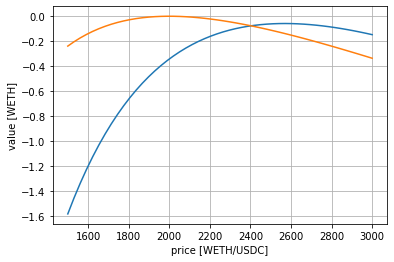

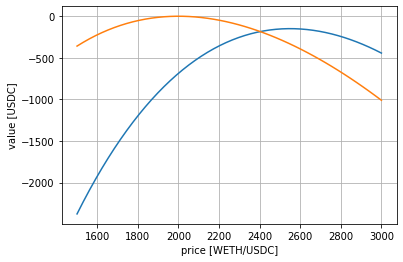

In [124]:
xr = np.linspace(1500, 3000, 50)
plt.plot(xr, [funcvx(x)/len(CC) for x in xr], label="all curves [scaled]")
plt.plot(xr, [funcvx0(x) for x in xr], label="curve 0 only")
plt.xlabel(f"price [{c0.pairp}]")
plt.ylabel(f"value [{c0.tknxp}]")
plt.grid()
plt.show()
plt.plot(xr, [funcvy(x)/len(CC) for x in xr], label="all curves [scaled]")
plt.plot(xr, [funcvy0(x) for x in xr], label="curve 0 only")
plt.xlabel(f"price [{c0.pairp}]")
plt.ylabel(f"value [{c0.tknyp}]")
plt.grid()
plt.show()

In [125]:
r = O.simple_optimizer()
print(f"Arbitrage gains: {-r.valx:.4f} {r.tknxp} [time={r.time:.4f}s]")

Arbitrage gains: 0.6731 WETH [time=0.0045s]


pair = WETH/USDC


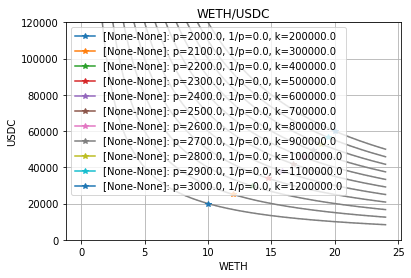

pair = WETH/USDC


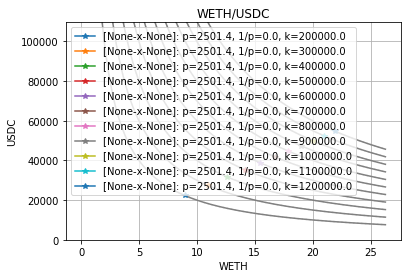

In [126]:
CC_ex = CPCContainer(c.execute(dx=dx) for c, dx in zip(r.curves, r.dxvalues))
CC.plot()
CC_ex.plot()

## MargP Optimizer Demo [NOTEST]

In [127]:
CCa = CPCContainer()
CCa += CPC.from_pk(pair="WETH/USDC", p=2000, k=10*20000, cid="c0")
CCa += CPC.from_pk(pair="WETH/USDT", p=2000, k=10*20000, cid="c1")
CCa += CPC.from_pk(pair="USDC/USDT", p=1.2, k=20000*20000, cid="c2")
O = MargPOptimizer(CCa)

pair = WETH/USDC


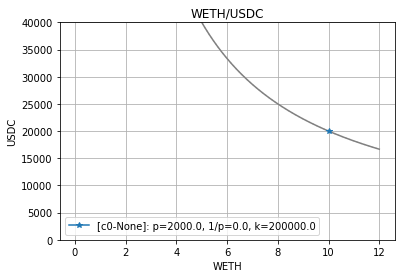

pair = USDC/USDT


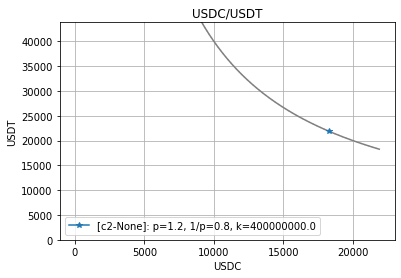

pair = WETH/USDT


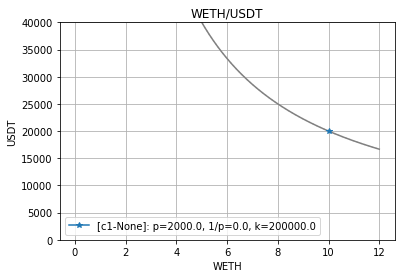

In [128]:
CCa.plot()

In [129]:
r = O.margp_optimizer("WETH", params=dict(verbose=True))
rd = r.asdict
r

[margp_optimizer] calculating price estimates
[margp_optimizer] pe   [0.0005 0.0005]
[margp_optimizer] p    0.00, 0.00
[margp_optimizer] 1/p  2,000.00, 2,000.00

[margp_optimizer] ========== cycle 0 =======>>>
log p0 [-3.3010299956639813, -3.3010299956639813]
log dp [-0.03004231  0.02281867]
log p  [-3.3310723  -3.27821133]
p      (0.0004665816971063286, 0.0005269733761120141)
p      0.00, 0.00
1/p    2,143.25, 1,897.63
tokens_t ('USDT', 'USDC')
dtkn -1,908.902, 1,742.581
[criterium=3.77e-02, eps=1.0e-06, c/e=4e+04]
<<<========== cycle 0 ======= [margp_optimizer]

[margp_optimizer] ========== cycle 1 =======>>>
log p0 [-3.331072301550902, -3.2782113257736367]
log dp [0.00203564 0.00197844]
log p  [-3.32903666 -3.27623289]
p      (0.0004687738067091822, 0.0005293794916778223)
p      0.00, 0.00
1/p    2,133.22, 1,889.00
tokens_t ('USDT', 'USDC')
dtkn 49.919, 43.132
[criterium=2.84e-03, eps=1.0e-06, c/e=3e+03]
<<<========== cycle 1 ======= [margp_optimizer]

[margp_optimizer] ========== c

CPCArbOptimizer.MargpOptimizerResult(result=-0.027643519043587972, time=0.004830121994018555, method='margp', targettkn='WETH', p_optimal_t=(0.0004687762137568585, 0.0005293821585804722), dtokens_t=(1.7826096154749393e-10, 1.4551915228366852e-10), tokens_t=('USDT', 'USDC'), errormsg=None)

In [130]:
rd

<bound method DCBase.asdict of CPCArbOptimizer.MargpOptimizerResult(result=-0.027643519043587972, time=0.004830121994018555, method='margp', targettkn='WETH', p_optimal_t=(0.0004687762137568585, 0.0005293821585804722), dtokens_t=(1.7826096154749393e-10, 1.4551915228366852e-10), tokens_t=('USDT', 'USDC'), errormsg=None)>

pair = WETH/USDC


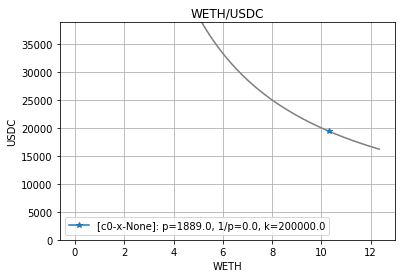

pair = USDC/USDT


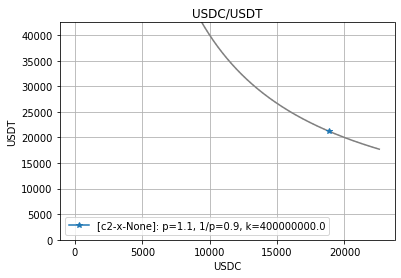

pair = WETH/USDT


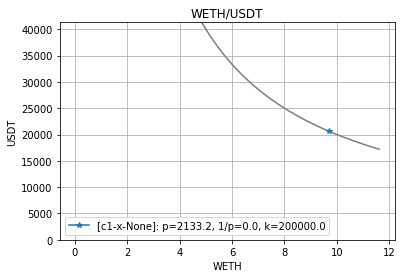

In [131]:
CCa1 = O.adjust_curves(r.dxvalues)
CCa1.plot()

## Optimizer plus inverted curves [NOTEST]

pair = WETH/USDC


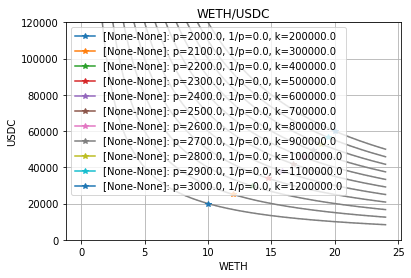

pair = USDC/WETH


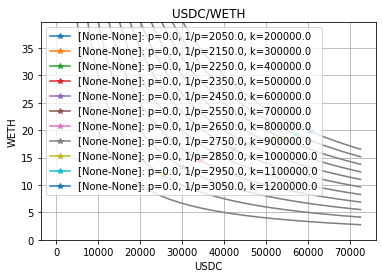

In [132]:
CCr = CPCContainer(CPC.from_pk(p=2000+i*100, k=10*(20000+10000*i), pair=f"{T.ETH}/{T.USDC}") for i in range(11))
CCi = CPCContainer(CPC.from_pk(p=1/(2050+i*100), k=10*(20000+10000*i), pair=f"{T.USDC}/{T.ETH}") for i in range(11))
CC  = CCr.bycids()
assert len(CC) == len(CCr)
CC += CCi
assert len(CC) == len(CCr) + len(CCi)
CC.plot()

Arbitrage gains: 1.3195 WETH [time=0.0102s]
prices post arb: [2527.721669597842, 2527.7216695978414, 2527.721669597842, 2527.721669597842, 2527.7216695978423, 2527.7216695978423, 2527.721669597842, 2527.721669597842, 2527.7216695978423, 2527.7216695978423, 2527.7216695978414, 2527.721669597843, 2527.7216695978423, 2527.721669597842, 2527.721669597843, 2527.721669597842, 2527.7216695978423, 2527.721669597843, 2527.7216695978427, 2527.7216695978423, 2527.7216695978423, 2527.7216695978423]
stdev 5.130242014436283e-13
pair = WETH/USDC


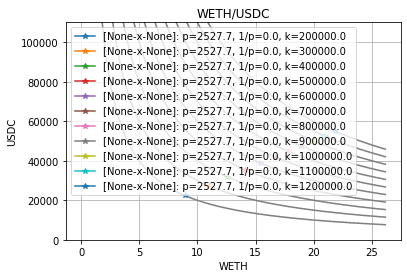

pair = USDC/WETH


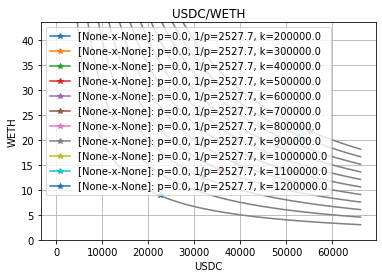

In [133]:
O = SimpleOptimizer(CC)
r = O.simple_optimizer()
print(f"Arbitrage gains: {-r.valx:.4f} {r.tknxp} [time={r.time:.4f}s]")
CC_ex = CPCContainer(c.execute(dx=dx) for c, dx in zip(r.curves, r.dxvalues))
prices_ex = [c.pairo.primary_price(c.p) for c in CC_ex]
print("prices post arb:", prices_ex)
print("stdev", np.std(prices_ex))
#CC.plot()
CC_ex.plot()

## Operating on leverage ranges [NOTEST]

In [134]:
N = 10

pair = WETH/USDC


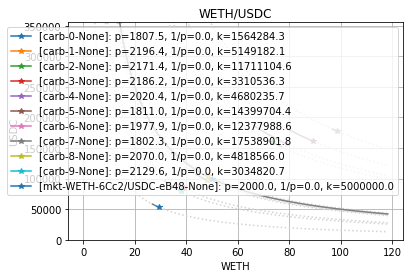

In [135]:
CCc, CCm, ctr = CPCContainer(), CPCContainer(), 0
U, U1 = CPCContainer.u, CPCContainer.u1
tknb, tknq = T.ETH, T.USDC
pb, pq = 2000, 1
pair = f"{tknb}/{tknq}"
pp = pb/pq
k = 100000**2/(pb*pq)
CCm += CPC.from_pk(p=pp, k=k, pair=pair, cid = f"mkt-{pair}", params=dict(xc="market"))
#print("\n***PAIR:", tknb, pb, tknq, pq, pair, pp)
for i in range(N):
    p = pp * (1+0.2*U(-0.5, 0.5))
    p_min, p_max = (p, U(1.001, 1.5)*p) if U1()>0.5 else (U(0.8, 0.999)*p, p)
    amtusdc = U(10000, 200000)
    k = amtusdc**2/(pb*pq)
    #print("*curve", int(amtusdc), p, p_min, p_max, int(k))
    CCc += CPC.from_pkpp(p=p, k=k, p_min=p_min, p_max=p_max, 
                         pair=pair, cid = f"carb-{ctr}", params=dict(xc="carbon"))
    ctr += 1
    
CC = CCc.bycids().add(CCm)
CC.plot()

In [136]:
# O = CPCArbOptimizer(CC)
# r = O.simple_optimizer()
# print(f"Arbitrage gains: {-r.valx:.4f} {r.tknxp} [time={r.time:.4f}s]")
# CC_ex = CPCContainer(c.execute(dx=dx) for c, dx in zip(r.curves, r.dxvalues))
# prices_ex = [c.pairo.primary_price(c.p) for c in CC_ex]
# print("prices post arb:", prices_ex)
# print("stdev", np.std(prices_ex))
# #CC.plot()
# CC_ex.plot()

In [137]:
r.dxvalues

(-1.1049094789463147,
 -1.0580695971194967,
 -0.9044395958543596,
 -0.6798225955379245,
 -0.40463958045259574,
 -0.09200995361981867,
 0.24902065596678824,
 0.611917896610187,
 0.9918034206287025,
 1.3849450080990486,
 1.7884329924488789,
 -0.9822054454422133,
 -0.9182719681479288,
 -0.7537756799228514,
 -0.5221261298376696,
 -0.24246720832973345,
 0.07285318547141273,
 0.4152913315845943,
 0.7786558054499011,
 1.1583108394561847,
 1.5507002894507451,
 1.9530448452302842)

## Arbitrage testing [NOTEST]

pair = WETH/USDC


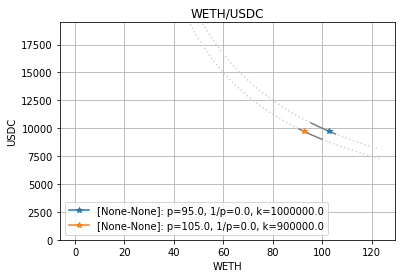

In [138]:
c1 = CPC.from_pkpp(p=95, k=100*10000, p_min=90, p_max=110, pair=f"{T.ETH}/{T.USDC}")
c2 = CPC.from_pkpp(p=105, k=90*10000, p_min=90, p_max=110, pair=f"{T.ETH}/{T.USDC}")
CC = CPCContainer([c1,c2])
CC.plot()

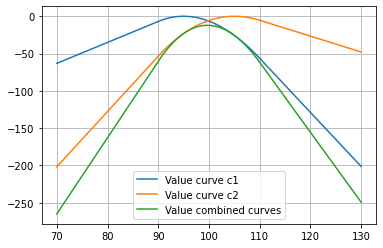

In [139]:
a = lambda x: np.array(x)
pr = np.linspace(70,130,200)
dx1, dy1, p = zip(*(c1.dxdyfromp_f(p) for p in pr))
assert np.all(p == pr)
dx2, dy2, p = zip(*(c2.dxdyfromp_f(p) for p in pr))
assert np.all(p == pr)
v1 = a(dy1)+a(p)*a(dx1)
v2 = a(dy2)+a(p)*a(dx2)
plt.plot(p, v1, label="Value curve c1")
plt.plot(p, v2, label="Value curve c2")
plt.plot(p, v1+v2, label="Value combined curves")
plt.legend()
plt.grid()

In [140]:
def vfunc(p):
    
    dx1, dy1, _ = c1.dxdyfromp_f(p)
    dx2, dy2, _ = c2.dxdyfromp_f(p)
    v1 = dy1 + p*dx1
    v2 = dy2 + p*dx2
    v = v1+v2
    #print(f"[v] v({p}) = {v}")
    return -v

In [141]:
O = CPCArbOptimizer
O.findmin(vfunc, 100, N=100)

OptimizerBase.SimpleResult(result=99.68104660486168, method='findminmax_nr', errormsg=None, context_dct=None)

In [142]:
func1 = lambda x: (x-2)**2
O.findmin(func1, 1)

OptimizerBase.SimpleResult(result=2.0, method='findminmax_nr', errormsg=None, context_dct=None)

In [143]:
func2 = lambda x: 1-(x-3)**2
O.findmax(func2, 2.5)

OptimizerBase.SimpleResult(result=3.000000000003396, method='findminmax_nr', errormsg=None, context_dct=None)

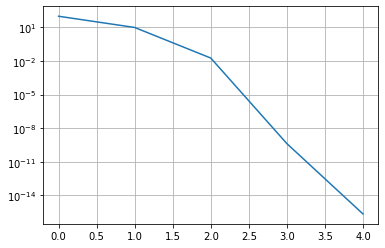

In [144]:
val = tuple(float(O.findmin(func1, 100, N=n)) for n in range(100))
val = tuple(abs(v-val[-1]) for v in val)
val = tuple(v for v in val if v > 0)
plt.plot(val)
plt.yscale('log')
plt.grid()

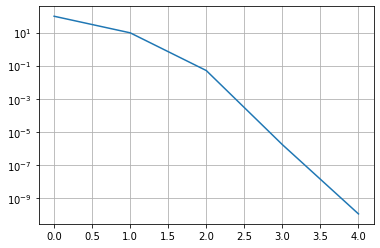

In [145]:
val = tuple(float(O.findmin(func2, 100, N=n)) for n in range(100))
val = tuple(abs(v-val[-1]) for v in val)
val = tuple(v for v in val if v > 0)
plt.plot(val)
plt.yscale('log')
plt.grid()

99.68103950148166


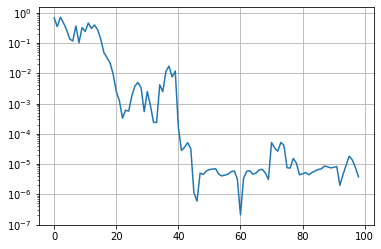

In [146]:
val0 = tuple(float(O.findmin(vfunc, 99, N=n)) for n in range(100))
val = tuple(abs(v-val0[-1]) for v in val0)
val = tuple(v for v in val if v > 0)
print(val0[-1])
plt.plot(val)
plt.yscale('log')
plt.grid()

99.68102109480606


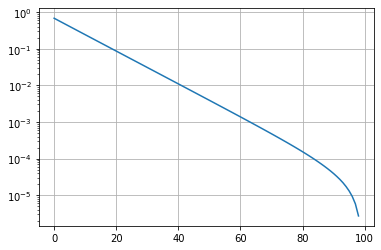

In [147]:
val0 = tuple(float(O.findmin_gd(vfunc, 99, N=n)) for n in range(100))
val = tuple(abs(v-val0[-1]) for v in val0)
val = tuple(v for v in val if v > 0)
print(val0[-1])
plt.plot(val)
plt.yscale('log')
plt.grid()

In [148]:
O.findmin(vfunc, 99, N=700)

OptimizerBase.SimpleResult(result=99.65287573579084, method='findminmax_nr', errormsg=None, context_dct=None)

## Charts [NOTEST]

### Chars (x,y)

In [149]:
xr = np.linspace(1,300,200)

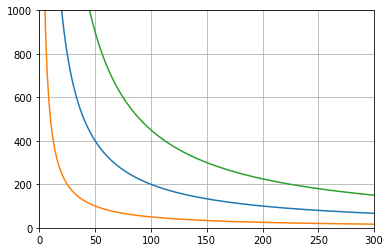

In [150]:
defaults = dict(p=2)
curves = [
    CPC.from_px(x=100, **defaults),
    CPC.from_px(x=50, **defaults),
    CPC.from_px(x=150, **defaults),
]
for c in curves:
    plt.plot(xr, [c.yfromx_f(x) for x in xr])

plt.ylim((0,1000))
plt.xlim((0,300))
plt.grid()

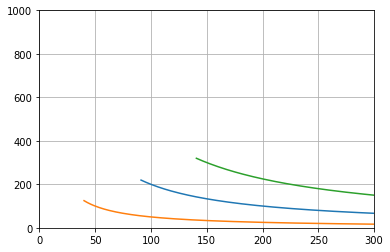

In [151]:
defaults = dict(p=2, x_act=10)
curves = [
    CPC.from_px(x=100, **defaults),
    CPC.from_px(x=50, **defaults),
    CPC.from_px(x=150, **defaults),
]
for c in curves:
    plt.plot(xr, [c.yfromx_f(x) for x in xr])

plt.ylim((0,1000))
plt.xlim((0,300))
plt.grid()

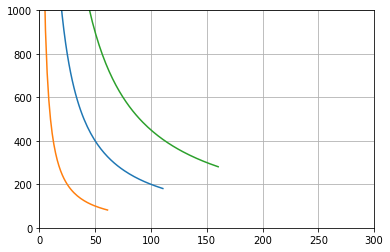

In [152]:
defaults = dict(p=2, y_act=20)
curves = [
    CPC.from_px(x=100, **defaults),
    CPC.from_px(x=50, **defaults),
    CPC.from_px(x=150, **defaults),
]
for c in curves:
    plt.plot(xr, [c.yfromx_f(x) for x in xr])

plt.ylim((0,1000))
plt.xlim((0,300))
plt.grid()

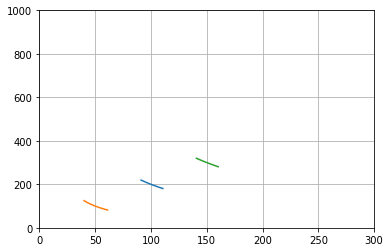

In [153]:
defaults = dict(p=2, x_act=10, y_act=20)
curves = [
    CPC.from_px(x=100, **defaults),
    CPC.from_px(x=50, **defaults),
    CPC.from_px(x=150, **defaults),
]
for c in curves:
    plt.plot(xr, [c.yfromx_f(x) for x in xr])

plt.ylim((0,1000))
plt.xlim((0,300))
plt.grid()

### Charts (dx, dy)

In [154]:
e=1e-5
dxr = np.linspace(-50+e,50-e,100)

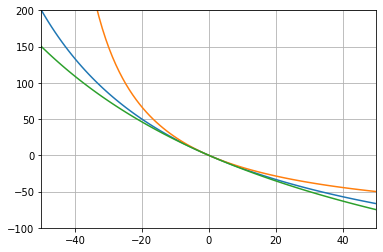

In [155]:
defaults = dict(p=2)
curves = [
    CPC.from_px(x=100, **defaults),
    CPC.from_px(x=50, **defaults),
    CPC.from_px(x=150, **defaults),
]
for c in curves:
    plt.plot(dxr, [c.dyfromdx_f(dx) for dx in dxr])

plt.ylim((-100,200))
plt.xlim((-50,50))
plt.grid()

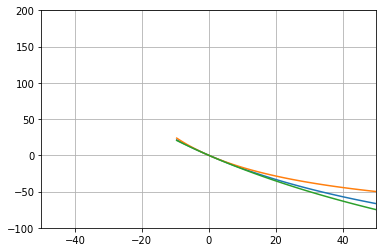

In [156]:
defaults = dict(p=2, x_act=10)
curves = [
    CPC.from_px(x=100, **defaults),
    CPC.from_px(x=50, **defaults),
    CPC.from_px(x=150, **defaults),
]
for c in curves:
    plt.plot(dxr, [c.dyfromdx_f(dx) for dx in dxr])

plt.ylim((-100,200))
plt.xlim((-50,50))
plt.grid()

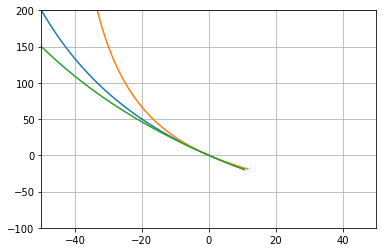

In [157]:
defaults = dict(p=2, y_act=20)
curves = [
    CPC.from_px(x=100, **defaults),
    CPC.from_px(x=50, **defaults),
    CPC.from_px(x=150, **defaults),
]
for c in curves:
    plt.plot(dxr, [c.dyfromdx_f(dx) for dx in dxr])

plt.ylim((-100,200))
plt.xlim((-50,50))
plt.grid()

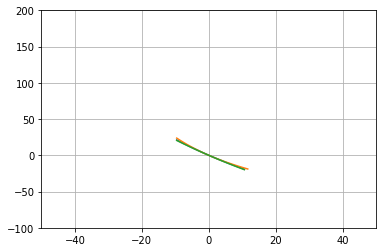

In [158]:
defaults = dict(p=2, x_act=10, y_act=20)
curves = [
    CPC.from_px(x=100, **defaults),
    CPC.from_px(x=50, **defaults),
    CPC.from_px(x=150, **defaults),
]
for c in curves:
    plt.plot(dxr, [c.dyfromdx_f(dx) for dx in dxr])

plt.ylim((-100,200))
plt.xlim((-50,50))
plt.grid()

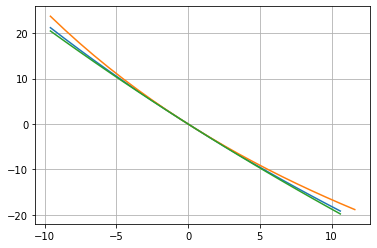

In [159]:
defaults = dict(p=2, x_act=10, y_act=20)
curves = [
    CPC.from_px(x=100, **defaults),
    CPC.from_px(x=50, **defaults),
    CPC.from_px(x=150, **defaults),
]
for c in curves:
    plt.plot(dxr, [c.dyfromdx_f(dx) for dx in dxr])

# plt.ylim((-100,200))
# plt.xlim((-50,50))
plt.grid()